### Что кажется логичным и что мы уже знаем:

1. Базово предсказание строится на 1 день вперед, то есть вполне используем лаги предыдущего дня. Для кросс-валидации смотрим промежуток - неделю и на ней замеряем качество прогнозов, на выходных (по флагам, о которых в пункте 2 todo) ставим нули (пункт 2 todo). Предположительно, стоит еще подумать над тем, чтобы замерять качество только на рабочих днях.
2. Переобучать модель стоит каждую неделю на выходных т.е. наша кросс-валидация будет предиктить по 1 дню.


### TODO:

1. **Добавить в бейзлайн (и другие модели) лаги с 1, а не с 7** (фильтрация с 7 идет на уровне модели в `__define_engineer_strategy_kws`), как сейчас, так как при прогнозировании мы будем на каждый день иметь возможность смотреть прошлые данные. Причем используем не прошлые наши прогнозы, а фактические данные. Скорее всего глобально нет смысла прогнозировать на 1 день всего лишь (а то мы выберем случайно только понедельники или только субботы), будем прогнозировать на неделю, но только за счет того, что мы генерируем лаги с 1 а не с 7, у нас в каждый из 7 дней будет доступна реальная информация и это будет аналогично прогнозу на 1 день 7 раз. Добавить это нужно прям в уже имеющийся модуль (поменять 1 строку) и запустить, посмотреть стало ли лучше/хуже.
2. **Доработать предобработку и предикт метод**: в предобработку мы оставляем флаги выходных и нерабочих дней, однако мы явно проставляем нулевой баланс в дни с флагом выходных и нерабочих (чтобы модель не учила ерунду), а далее в предикте надо сделать явное проставление нулей уже после того, как модель сделала предикт, используя все те же флаги выходных и нерабочих дней. Добавить нужно уже в имеющийся модуль с инженерами и уже имеющийся модуль с бейзлайн моделью.
3. **Собрать модули с оберточным отбором фичей и фильтрационным на основе взаимной информации**. Провести сравнение бейзлайна с 3 методами отбора фичей, а также провести кросс-валидацию и посмотреть, насколько вообще выбор фичей стабилен (в бейзлайне id сплитов сохраняются в self.splits, можно просто взять оттуда и явно сверху сделать функцию и протестировать то, как варьируется выбор фичей). Примерные идея: использовать просто частотность выбора фичей, типо на 5 фолдах в 4 выбрали фичу X. Далее считаем среднее число фолдов, в которых была выбрана фича, наиболее стабильный метод будет иметь наибольшее среднее.
4. **Собрать модель automl, потестировать на кросс-валидации** и проверить качество, сравнить с бейзлайном и либо переходим на эту модель, либо остаемся на катбусте.
5. **Собрать метрику `adjusted_target_loss` и добавить ее в `src/metrics.py`**. Должна принимать y_true, y_pred, rate (временной ряд со ставками, согласованный с y_true и y_pred), penalty (какой штраф, если выходим за threshold по модулю), threshold (порог для применения доп. штрафа, по дефолту он 0.42). Протестировать эту метрику, использовав ее для отбора гиперпараметров (можно передать через параметры бейзлайн-модели) в качестве основной, а также вместе с ней просто для справки считать старый лосс с фиксированной ставкой. Посмотреть, есть ли улучшение (не выходим ли мы за границы, которые устанавливает бизнес, падает ли при этом MAE по сравнению с нулевым штрафом).
6. **Собрать модуль для выявления разладки.** Общая идея: на вход принимает предикт модели за N дней (прошлое) и реальные фактические данные за эти же N дней. На выходе флаг -> была разладка или не было разладки.
7. **Попробовать добавить в бейзлайн фичи с притоками и оттоками** (их лаги так же с 1 по 30). Возможно кроме разности нам как раз могут помочь абсолюты. Тут важно не забыть, что если мы добавляем эти фичи, то надо пересчитать баланс как разницу между притоками и оттоками. Предположительно лучше попробовать сделать это в отдельном ноутбуке, и, если это улучшит метрики, нужно будет написать инженера фичей, стратегию, и после этого подумать, либо добавим в бейзлайн, либо сделаем отдельную модель.
8. Подумать, может, мы сможем в модель добавить фичи по типу "заседание цб в этот день", "дата выхода платежного баланса РФ", "даты аукционов минфина" и прочие штуки.
9. Поиграться с добавлением фичей с мосбиржей, долларом, золотом и т.д.

---

### Старые идеи

- ***Ресерч нового***
    1. Поиски новых моделей и реализация их в коде в `src/models.py` наподобие `BaselineModel`:
        1. `lightautoml`
        2. Еще другие штуки
        3. Нейронки из-за малого набора данных, кажется, не прям имеет смысл тестировать
    2. Новые признаки - что еще можно/нужно учесть:
        1. Макроэкономические показатели, влияющие на притоки/оттоки?
        2. Поиск причин аномалий в данных (посмотреть, где модель может сильно ошибаться и почему могло так произойти)
- ***Углубление в то, что имеем***
    1. Необходимо посмотреть на разности предсказаний внимательнее и, возможно, подумать, как можно обойти факт ковида и правильно ли мы вообще берем промежуток.
    2. Улучшение текущей модели
       1. Расширение сетки и увеличение числа итераций
       2. Изменение длины train/test и оценка того, как будет работать модель в будущем
    3. Поиск причин для объяснения увеличения дисперсии модели в конце промежутка
    4. Как учитывать то, что ставка меняется во времени? Нужно ли нам пересчитывать метрику каждый раз в зависимости от ruonia в этот день? Если да, нужно реализовать лосс с поддержкой этой фичи.
- ***Кодинг по заданию***
    1. Сейчас используется только катбуст и только встроенный feature_importance для отбора фичей, необходимо реализовать в `src/feature_selection/selectors.py` оберточный метод отбора фичей, а также фильтрационный на основе взаимной информации из sklearn и, соответственно, провести тесты всего этого добра, посравнивать наборы фичей, метрики и прочее.
    2. Нужна документация + комментарии по коду + хотя бы грубое описание входных данных. Предлагаю использовать одинаковый стиль для комментариев, поставить его можно в vs code, расширение auto docstring, стиль numpy (пример есть в `src/model_evaluation/metrics.py`)
    3. Нужен модуль для выявления разладки, который по факту должен делать что-то вроде считать на истории predict (или брать прошлый предикт?), брать реальные значения, и, типо если за последнюю неделю ошибка больше, чем X, то делаем экстренное переобучение. Бейзлайново, думаю, что можно зафитить одну модель и использовать ее для предикта, например, на 2 недели или на месяц (зависит от того как выберем).

---

### Вопросики и ответы

1. Как быть с метрикой: "не выше 0.42" в среднем или вообще для каждого случая?
    - Да, либо надо обосновать почему это требование плохое и почему наша модель все равно хорошая.
    - Модель прогнозирует на следующий день, то есть можно юзать все лаги вплоть до лага "значение вчера". Прогноз на день следующий и при этом ошибка не выше 0.42 (можно использовать как угодно модель, хоть переобучать каждый день, или переискивать параметры - на наш выбор). У них во варианте переобучалась на выходных, когда транзакций нет.
    - На выходных можно всегда брать нули, обычно там ноль везде.
2. Спросить про разладки, что должен делать модуль, должен ли он опираться только на ряд или на предикт модели , должен ли он придумывать промежуток для обучения после разладки или нет?
    - Разладка на наш выбор как будет работать - можно разность модели, можно на ряд смотреть. Требований нет, главное, чтобы работало.
    - Для разладки в базовой истории нужно просто уметь определить момент разладки и подать сигнал, а выбор промежутка для экстренного дообучения - это уже на доп.
3. Есть ли бизнесовая история о том, что происходило с банком в эти промежутки? Почему растет дисперсия?
4. Что значит "Модель должна автоматически дообучаться?". Если есть model fit predict с указанием глубины промежутков, этого достаточно?
    - Да
5. Если юзаем притоки оттоки, то надо пересчитать сальдо вручную как входные минус выходные. 
6. К какой дате нужна презентация - к защите или к сдаче в конце апреля?
    - Преза к защите, код к концу апреля.
7. Как строить выступление: как для бизнеса, или просто защита проекта?
    - Скорее как для бизнеса но устройство сутевое (по модулями и как работают) тоже нужно. Считаем, что заказчик бизнесовый, но понимает в процессе.

## Задание

### Введение
- В рамках проекта №2 требуется реализовать автоматизированный пайплайн для прогнозирования значений временного ряда на следующий день.
- Ряды представляют из себя срезы в обозначенные моменты времени притоков, оттоков и сальдо показателя, связанного с потоками ликвидности Банка
- Прогноз требуется строить для значения сальдо (разнинцы между притоками и оттоками)
- Заказчик модели высказал пожелание, чтобы ошибка прогноза составляла не более 0.42 в абсолютном значении

---

### Требования к модели:

- Выбор оптимизируемой метрики должен быть основан на потребностях бизнеса
- Модель может использовать внешние факторы (см подсказки)
- Модель должна иметь модуль отбора признаков. Метод отбора должен быть болеее стабильным относительно альтернатив. Сравнение должно быть проведено минимум с одним методом из каждой категории: встроенные, оберточные и фильтрационные. При этом как минимум одна из альтернатив должна исследовать нелинейную зависимость.
- Модель должна автоматически подбирать гиперпараметры, оптимизируя целевую метрику
- Для модели должна быть подобрана частота калибровки, если модель калибруется долго, и проверена ее достаточность
- Блоки должны быть подписаны и кратко описаны (чем руководствовались при реализации, как работает)
- Модель должна автоматически дообучаться. Все модули должны работать без ручных корректировок. Выбор периода для дообучения должен быть обоснован.
- В модели должен быть модуль выявления разладки для подачи сигнала о возможной необходимости переключения на на ручное управление процессом/внеплановое дообучение

---

### Подсказки:
- Можно использовать факторы, сконструированные из таргета (лаги, средние и т.п.)
- Могут помочь макроэкономические факторы
- Могут помочь даты налоговых дней

### Описание бизнес-процесса:

- Прогнозная величина позволяет установить сальдо поступлений и списаний за день.
- На основании прогноза позиционер (управляет ликвидностью) принимает решение о выделении средств на размещение на рынке деривативов для получения дополнительной маржи (доходность считать примерно ключ+0.5%)
- В случае, если на конец дня образуется профицит ликвидности, его можно разместить в ЦБ по overnight ставке, равной ключу-0.9%
- В случае, если на конец дня образуется дефицит ликвидности, его можно покрыть за счет займа по overnight ставке, равной ключ+1%

## Выбор метрики

Введем несколько величин:
- $r_{key}$ - ключевая ставка
- $r_{add}$ - ставка при размещении деривативов для получения дополнительной маржи. $r_{add} = r_{key} + 0.5$
- $r_{surplus}$ - ставка по профицитной ликвидности, размещаемой по overnight-ставке в ЦБ. $r_{surplus} = r_{key} - 0.9$
- $r_{deficit}$ - ставка по дефицитной ликвидности, которую приходится привлекать за счет займа в ЦБ. $r_{deficit} = r_{key} + 1$

Предположим, что у нас есть некоторое предсказание $\hat{b}_t$ - сальдо на день $t$, а также реальное значение ${b}_t$ сальдо за этот день. Существует 2 основных сценария действий:
- $\hat{b}_t > 0$, тогда полученные средства могут быть размещены в деривативы для получения маржи под ставку $r_{add}$, таким образом образуется дополнительная доходность $\hat{b}_t \cdot r_{add}$.
- $\hat{b}_t < 0$, тогда необходимо заимствовать деньги под $r_{deficit}$, таким образом генерируется убыток $\hat{b}_t \cdot r_{deficit}$

При этом в зависимости от того, какое сальдо будет по факту, мы можем попасть в две ситуации:
- $\hat{b}_t > b_t$, то есть было предсказано больше, чем пришло по факту. Таким образом, нам придется занимать у цб $\hat{b}_t-b_t$ средств под ставку $r_{deficit}$, чтобы покрыть дефицит на день, при этом мы заработаем $\hat{b}_t \cdot r_{add}$ за счет размещения средств в деривативы.
- $\hat{b}_t < b_t$, то есть было предсказано меньше, чем пришло по факту. Таким образом, потеря будет в том, что мы недозаработали $(b_t - \hat{b}_t) \cdot (r_{add} - r_{surplus})$ денег, так как вместо размещения в деривативы будем вынуждены размещать под overnight.

In [8]:
ts_filepath = 'data/project_2.csv'
holidays_filepath = 'data/holidays.pickle'
taxes_filepath = 'data/taxes.csv'
rate_filepath = 'data/rounia.xlsx'
inflation_filepath = 'data/inflation_and_cb_rate.xlsx'
currency_path = 'data/usd.csv'
moex_path = 'data/IMOEX.csv'

In [9]:
%load_ext autoreload
%autoreload 2

import warnings
import requests
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import plotly.graph_objects as go
from matplotlib.ticker import AutoMinorLocator
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

from src.models import BaselineModel # Наша модель

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Загрузка данных

## Временной ряд

In [10]:
data = pd.read_csv(ts_filepath)
data.columns = [col.lower() for col in data]
data['date'] = pd.to_datetime(data['date'])
for col in data.columns[1:]:
    data[col] = data[col].astype(str).str.replace(',', '.').astype(float)
data = data.set_index('date')
print(data.shape)
display(data.describe().round(3))
data.head()

(1543, 3)


,income,outcome,balance
count,1543.000,1543.000,1543.000
mean,1.085,1.134,-0.049
std,0.839,0.902,0.292
min,0.000,0.000,-2.510
25%,0.000,0.000,-0.143
50%,1.330,1.330,0.000
75%,1.670,1.740,0.038
max,5.110,5.000,1.410


,income,outcome,balance
date,,,
2017-01-09,1.340000,1.490000,-0.155904
2017-01-10,1.068610,1.194182,-0.125572
2017-01-11,0.944429,0.936663,0.007767
2017-01-12,1.670000,0.875379,0.800391
2017-01-13,0.955924,0.975645,-0.019721


In [11]:
data.isnull().sum()

income     0
outcome    0
balance    0
dtype: int64

In [12]:
all_dates = pd.DataFrame({
    'date': pd.date_range(data.index.min(), data.index.max(), freq='D')
})
all_data = pd.merge(
    left=all_dates,
    right=data.reset_index(),
    on=['date'],
    how='left'
).set_index('date')
all_data.isnull().sum()

income     0
outcome    0
balance    0
dtype: int64

In [13]:
data.index.min(), data.index.max()

(Timestamp('2017-01-09 00:00:00'), Timestamp('2021-03-31 00:00:00'))

**Отлично, в данных нет пропусков и присутствует информация за каждый день с 09.01.2017 по 31.03.2021**

Посмотрим как выглядит ряд далее после загрузки остальных данных

## Даты уплаты налогов и их типы

In [14]:
def _parse_links_with_calendars_from_tax_page(url: str):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    div = soup.find('div', class_='document-page__toc').find('ul')
    link_to_calendar = 'https://www.consultant.ru' + div.find(lambda tag: 'Часть 3. Тематический Календарь' in tag.text and tag.name == 'a').attrs['href']
    calendar_page = BeautifulSoup(requests.get(link_to_calendar).text, 'html.parser')
    tax_types_info = [c for c in calendar_page.find('div', 'document-page__toc').contents if c.text.strip(' \n')][0]
    links = ['https://www.consultant.ru/' + item.attrs['href'] for item in tax_types_info.findAll('a')]
    return links

def _parse_tax_dates_from_tax_calendar_page(url: str):
    r = requests.get(url)
    soup = BeautifulSoup(r.text)
    columns = soup.find('div', class_='doc-table').findAll('td')
    tax_type = columns[0].text.replace('\n', '')
    tax_result = {
        tax_type: {}
    }
    tax_subtype = ''
    prev_paragraph_has_dates = True
    for paragraph in columns[1].findAll('p'):
        if paragraph.text:
            all_links = paragraph.findAll('a')
            has_dates = len(all_links) > 1
            if has_dates:
                dates_to_add = [
                     item.text for item in all_links 
                     if all([letter.isdigit() for letter in item.text.replace('.', '')])
                ]
                dates_to_add = [
                    item for item in dates_to_add if item
                ]
                if dates_to_add:
                    if not tax_subtype:
                        tax_subtype = 'no_type'
                    if tax_subtype in tax_result:
                        tax_result[tax_type][tax_subtype] += dates_to_add
                    else:
                        tax_result[tax_type][tax_subtype] = dates_to_add
            else:
                if prev_paragraph_has_dates:
                    tax_subtype = ''
                tax_subtype += paragraph.text + ' '
                prev_paragraph_has_dates = False
    return tax_result

In [15]:
if os.path.exists(taxes_filepath):
    taxes = pd.read_csv(taxes_filepath)
else:
    dicts = []
    urls = {
        2017: 'https://www.consultant.ru/document/cons_doc_LAW_208577/',
        2018: 'https://www.consultant.ru/document/cons_doc_LAW_284538/',
        2019: 'https://www.consultant.ru/document/cons_doc_LAW_312984/',
        2020: 'https://www.consultant.ru/document/cons_doc_LAW_339977/',
        2021: 'https://www.consultant.ru/document/cons_doc_LAW_371805/'
    }
    taxes = []
    for year, url in urls.items():
        links = _parse_links_with_calendars_from_tax_page(url)
        cur_taxes = {}
        for link in links:
            cur_taxes |= _parse_tax_dates_from_tax_calendar_page(link)
        year_taxes = []
        for tax_type, values in cur_taxes.items():
            for tax_subtype, tax_dates in values.items():
                cur_df = pd.DataFrame(tax_dates)
                cur_df.columns = ['date']
                # Ошибка в К+ на 2020 годе
                cur_df['date'] = cur_df['date'].str.replace('20.20', '20.10')
                cur_df['date'] = pd.to_datetime(
                    cur_df['date'] + f'.{year}', format='%d.%m.%Y'
                )
                cur_df['tax_type'] = tax_type
                cur_df['tax_subtype'] = tax_subtype
                year_taxes.append(cur_df)
        year_taxes = pd.concat(year_taxes)
        taxes.append(year_taxes)
    taxes = pd.concat(taxes)
    taxes.to_csv(filepath, index=False)
taxes['date'] = pd.to_datetime(taxes['date'])
taxes.head()

,date,tax_type,tax_subtype
0,2017-01-20,Сведения о среднесписочной численности работников,no_type
1,2017-02-20,Сведения о среднесписочной численности работников,no_type
2,2017-03-20,Сведения о среднесписочной численности работников,no_type
3,2017-04-20,Сведения о среднесписочной численности работников,no_type
4,2017-05-22,Сведения о среднесписочной численности работников,no_type


## Выходные и рабочие дни

In [16]:
if os.path.exists(holidays_filepath):
    with open(holidays_filepath, 'rb') as f:
        holidays = pickle.load(f)
else:
    years = np.unique(data.index.year)
    holidays = {
        'holidays': [],
        'preholidays': [],
        'nowork': []
    }
    for year in years:
        url = f'https://raw.githubusercontent.com/d10xa/holidays-calendar/master/json/consultant{year}.json'
        r = requests.get(url)
        cal = json.loads(r.text)
        for key, val in cal.items():
            holidays[key] += val
    with open(holidays_filepath, 'wb') as f:
        pickle.dump(holidays, f)
for key in holidays:
    holidays[key] = pd.to_datetime(holidays[key])
print(holidays.keys())
holidays

dict_keys(['holidays', 'preholidays', 'nowork'])


{'holidays': DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
                '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
                '2017-01-14', '2017-01-15',
                ...
                '2021-11-28', '2021-12-04', '2021-12-05', '2021-12-11',
                '2021-12-12', '2021-12-18', '2021-12-19', '2021-12-25',
                '2021-12-26', '2021-12-31'],
               dtype='datetime64[ns]', length=591, freq=None),
 'preholidays': DatetimeIndex(['2017-02-22', '2017-03-07', '2017-11-03', '2018-02-22',
                '2018-03-07', '2018-04-28', '2018-05-08', '2018-06-09',
                '2018-12-29', '2019-02-22', '2019-03-07', '2019-04-30',
                '2019-05-08', '2019-06-11', '2019-12-31', '2020-06-11',
                '2020-11-03', '2020-12-31', '2021-02-20', '2021-04-30',
                '2021-06-11', '2021-11-03'],
               dtype='datetime64[ns]', freq=None),
 'nowork': DatetimeIndex(['2020-03-30', '2020-03-31', '20

## Ставка

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rate_df = pd.read_excel(rate_filepath, engine="openpyxl")
rate_df['date'] = pd.to_datetime(rate_df['DT'])
rate_df = rate_df[['date', 'ruo']].rename(columns={'ruo': 'rate'})
rate_df = rate_df.sort_values('date').set_index('date')
rate_df.head()

,rate
date,
2017-01-09,10.13
2017-01-10,9.93
2017-01-11,9.97
2017-01-12,9.93
2017-01-13,10.06


In [18]:
# Предлагаю следующие экзогенные параметры:
# Инфляция
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    inflation_df = pd.read_excel(inflation_filepath, engine="openpyxl") 
inflation_df['Дата'] = inflation_df['Дата'].astype(str)

def fix_year(date_str):
    parts = date_str.split('.')
    if len(parts) == 2:
        month, year = parts
        if len(year) == 3:
            year += '0'
        return f"{month}.{year}"
    return date_str

inflation_df['Дата'] = inflation_df['Дата'].apply(fix_year)
inflation_df['date'] = pd.to_datetime(inflation_df['Дата'], format='%m.%Y')
inflation_df = inflation_df[['date', 'Инфляция, % г/г']].rename(columns={'Инфляция, % г/г': 'inflation'})
inflation_df = inflation_df.sort_values('date').set_index('date')
inflation_df.head()

,inflation
date,
2017-01-01,5.0
2017-02-01,4.6
2017-03-01,4.3
2017-04-01,4.1
2017-05-01,4.1


In [19]:
# Изменение курса доллара к предыдущему дню в процентах
currency_df = pd.read_csv(currency_path).set_index('date')
currency_df = (currency_df / currency_df.shift(1) - 1) * 100
currency_df = currency_df[1:]
currency_df.head()

,value
date,
2017-01-11,0.095499
2017-01-12,0.347103
2017-01-13,-1.103033
2017-01-14,-0.214798
2017-01-17,0.398686


In [20]:
# Индекс Мосбиржи:
moex_df = pd.read_csv(moex_path, encoding='windows-1251', sep=';').set_index('TRADEDATE')
moex_df = pd.DataFrame(moex_df['CLOSE'].str.replace(',', '.').astype(float))
moex_df = (moex_df / moex_df.shift(1) - 1) * 100
moex_df = moex_df[1:]
moex_df.head()

,CLOSE
TRADEDATE,
04.01.2017,-0.942055
05.01.2017,-1.923672
06.01.2017,-0.289144
09.01.2017,-0.121052
10.01.2017,1.186659


## Вспомогательные функции для визуализации

In [21]:
def make_ax_better(ax, locators=(), n_locators=None):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if 'x' in locators:
        ax.xaxis.set_minor_locator(AutoMinorLocator(n_locators))
    if 'y' in locators:
        ax.yaxis.set_minor_locator(AutoMinorLocator(n_locators))
    if locators:
        ax.tick_params(which='minor', length=2.5)
        ax.tick_params(which='major', length=5)
        ax.grid(which='minor', linewidth=0.15, color='tab:grey', alpha=0.25)
    ax.grid(linewidth=0.5, color='tab:grey', alpha=0.25)
    
def to_bold(s):
    s = ' '.join([r"$\bf{" + str(item) + "}$" for item in s.split(' ')])
    return s.replace('_', '}$_$\\bf{')

def plot_ts_plotly(
    series_list: list[pd.Series],
    colors: list[str] = ['#42CAFD'],
    title: str = '',
    xaxis_title: str = '',
    yaxis_title: str = '',
    fig_size: tuple[int, int] = (1000, 600),  # Размер фигуры (ширина, высота)
    v_lines: list[dict] = []
):
    # Создаем фигуру
    fig = go.Figure()
    for series, color in zip(series_list, colors):
        fig.add_trace(
            go.Scatter(
                x=series.index,
                y=series,
                mode='lines',
                name=series.name,
                line=dict(color=color),
                meta=[series.name],
                hovertemplate='<b>%{meta[0]}: %{y:.3f}</b><extra></extra>'  # Добавляем название тикера
            )
        )

    # Настраиваем заголовок и оси
    fig.update_layout(
        title={
            'text': title,
            'y': 0.95,  # Позиция заголовка по вертикали
            'x': 0.5,    # Позиция заголовка по горизонтали (центр)
            'xanchor': 'center',  # Центрируем заголовок
            'yanchor': 'top',     # Привязка к верхней части
            'font': dict(size=22)  # Размер шрифта заголовка
        },
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        template='plotly_white',
        legend=dict(
            x=0.5,  # Центрируем легенду по горизонтали
            y=-0.2,  # Размещаем легенду ниже графика
            xanchor='center',  # Привязка к центру
            yanchor='top',     # Привязка к верхней части
            orientation='h',  # Горизонтальная ориентация
            font=dict(size=12),  # Размер шрифта легенды
            traceorder='normal',  # Порядок элементов легенды
            itemwidth=50,  # Ширина элемента легенды
            itemsizing='constant',  # Фиксированный размер элементов
            bordercolor='lightgray',  # Цвет границы легенды
            borderwidth=1,  # Ширина границы легенды
            bgcolor='rgba(255, 255, 255, 0.8)',  # Цвет фона легенды
            # columns=legend_cols  # Количество столбцов в легенде
        ),
        hovermode='x unified',
        width=fig_size[0],  # Ширина фигуры
        height=fig_size[1],  # Высота фигуры
        margin=dict(l=50, r=50, b=50, t=100)  # Отступы (left, right, bottom, top)
    )
    fig.update_xaxes(rangeslider_visible=True)

    # Настраиваем оси
    fig.update_xaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        minor=dict(
            ticklen=4,  # Длина minor-тиков
            tickcolor='gray',  # Цвет minor-тиков
            showgrid=True,  # Показываем minor-сетку
            gridcolor='rgba(211, 211, 211, 0.5)',  # Цвет minor-сетки (светло-серый с прозрачностью)
            griddash='dot'  # Стиль minor-сетки (точечный)
        )
    )
    fig.update_yaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        minor=dict(
            ticklen=4,  # Длина minor-тиков
            tickcolor='gray',  # Цвет minor-тиков
            showgrid=True,  # Показываем minor-сетку
            gridcolor='rgba(211, 211, 211, 0.5)',  # Цвет minor-сетки (светло-серый с прозрачностью)
            griddash='dot'  # Стиль minor-сетки (точечный)
        )
    )
    for v_line_kws in v_lines:
        fig.add_vline(
            x=str(v_line_kws['x']), 
            line_width=2,
            line_dash="dash", 
            line_color=v_line_kws.get('color', '#292F36'), 
        )

    # Показываем график
    fig.show()


# Анализ данных

Посмотрим на исследуемый ряд

In [22]:
colors = ['#69995D', '#1985A1', '#C95D63']
for col, color in zip(data.columns, colors):
    plot_ts_plotly([data[col]], title=col, colors=[color])

Попробуем разделить баланс на компоненты. Так как он может быть отрицательным, посмотрим только на аддитивные составляющие

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\ilya\AppData\Local\

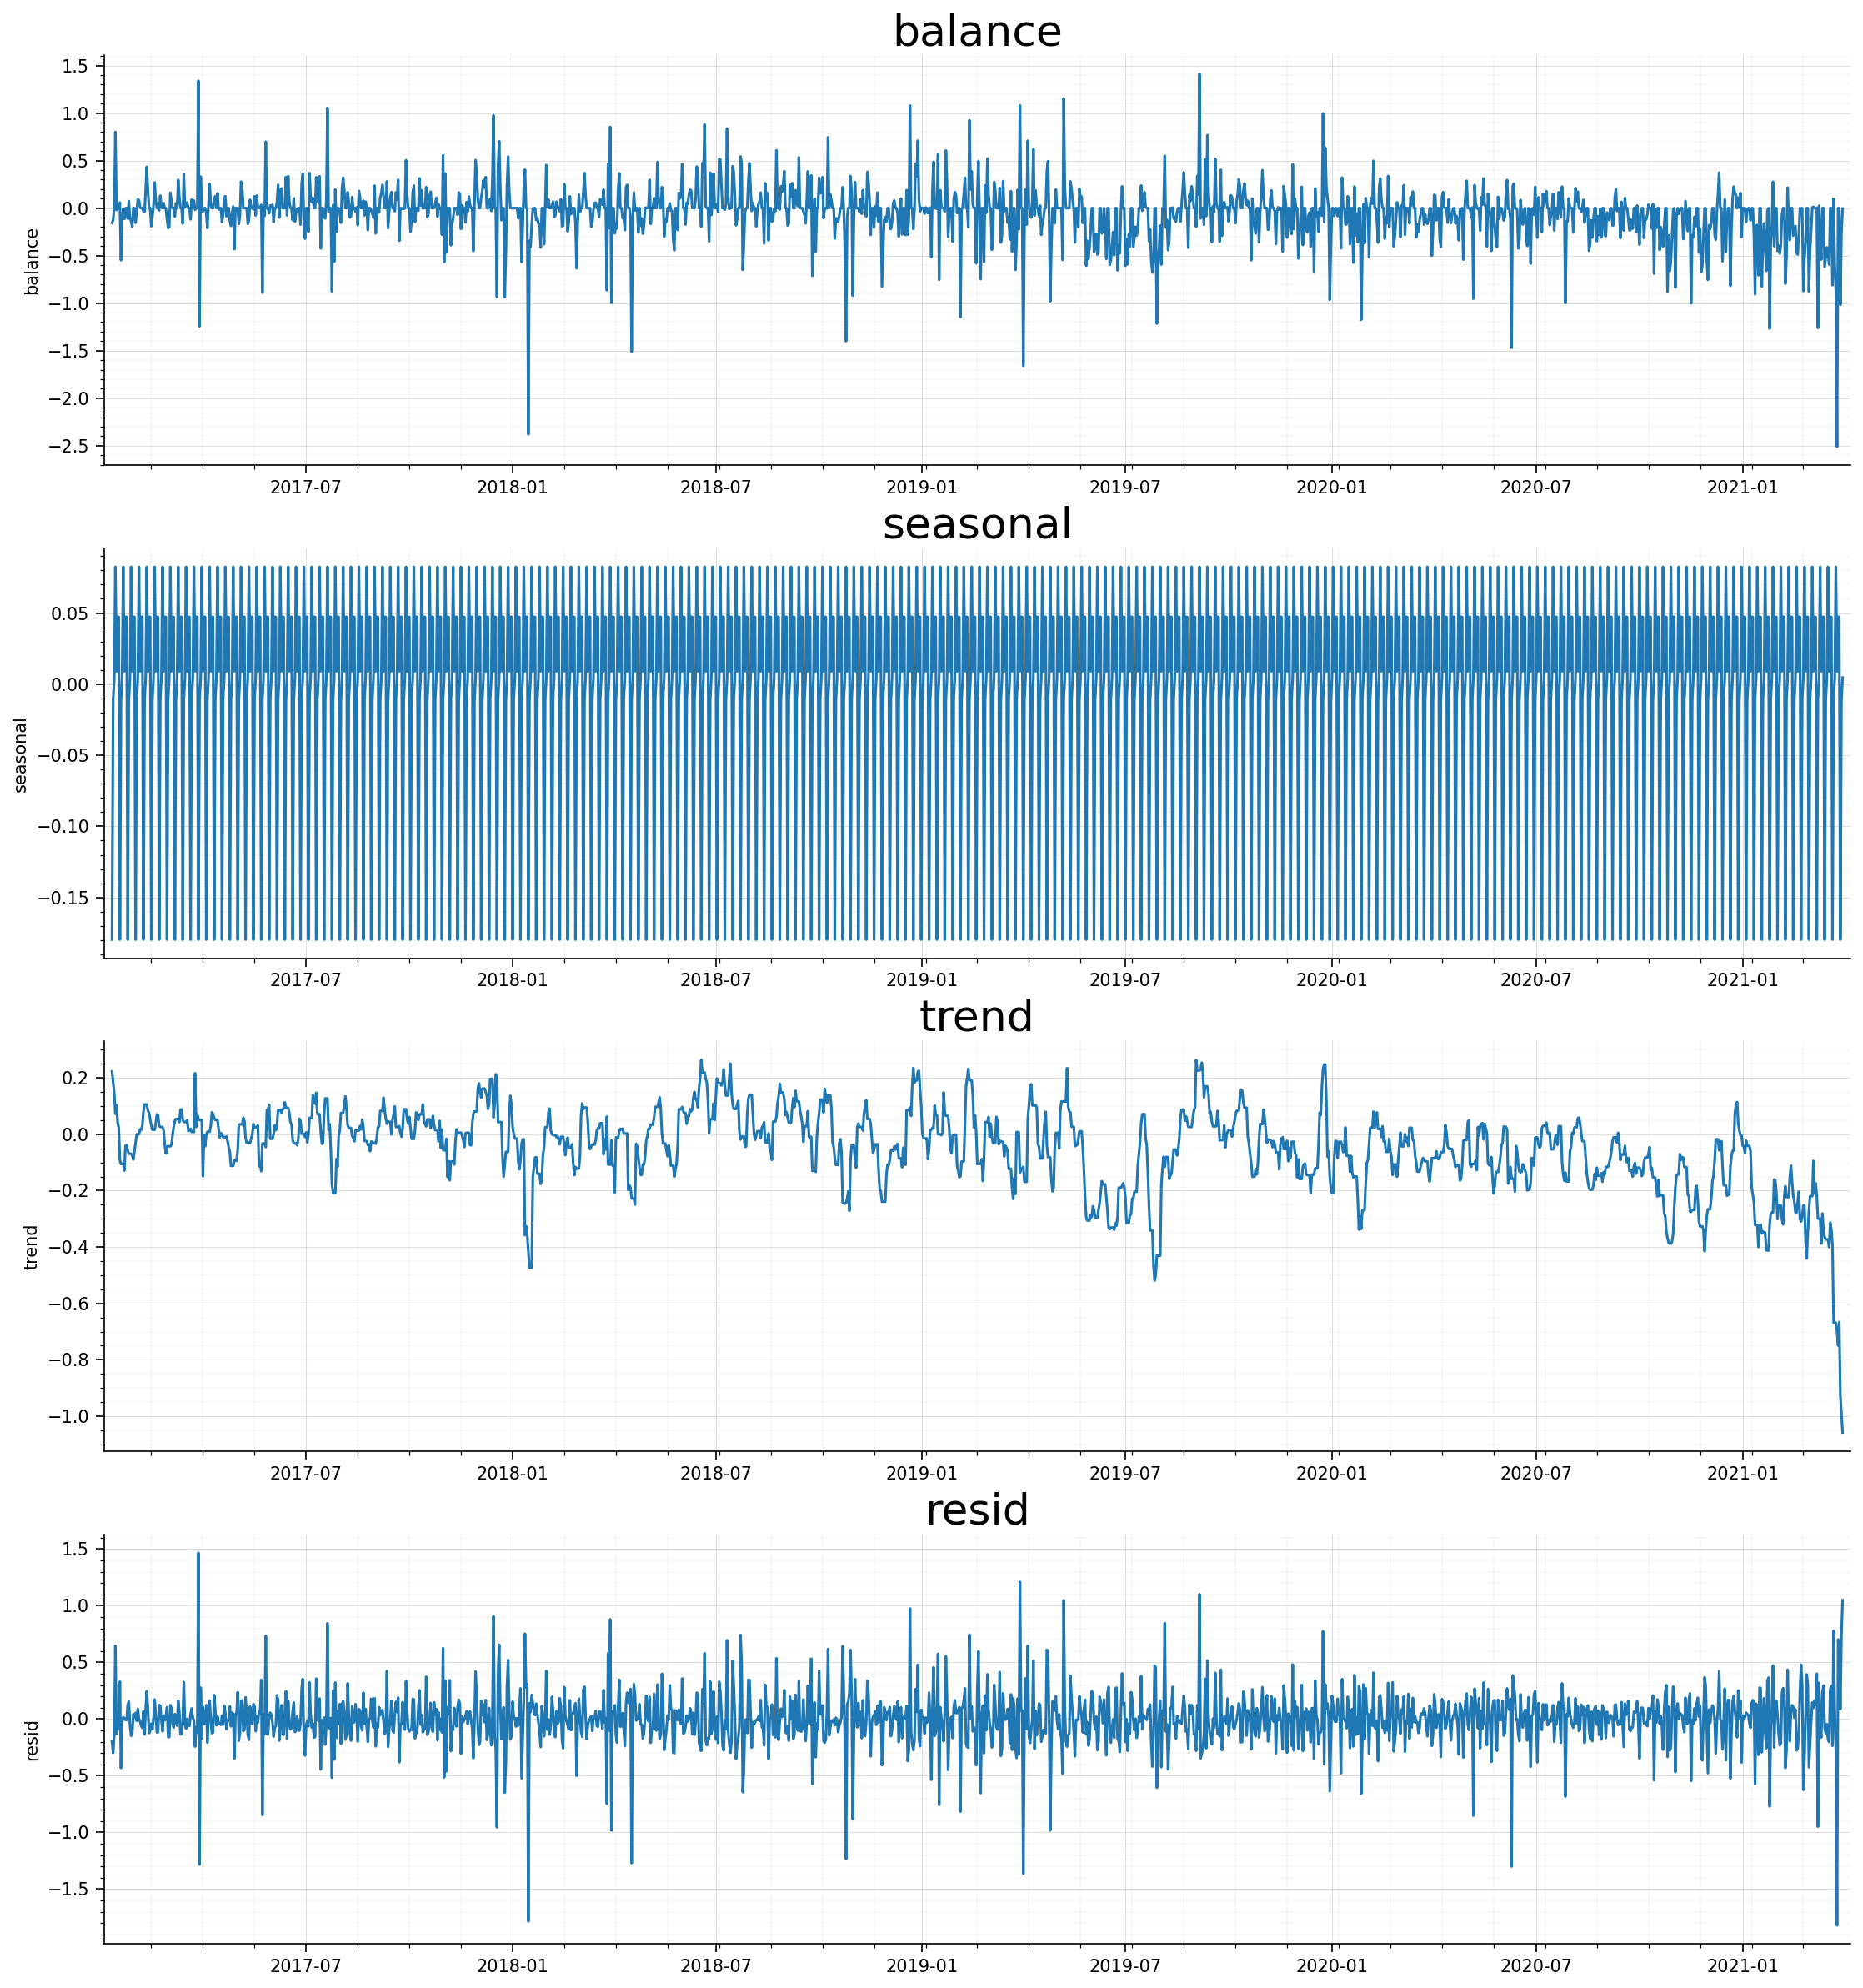

In [23]:
def plot_decomposed_ts(
    ts: pd.Series,
    model: str = 'additive',
    color: str = 'tab:blue'
):
    decomposed = seasonal_decompose(ts, model=model, extrapolate_trend='freq')
    decomposed = pd.concat([decomposed.observed, decomposed.seasonal, decomposed.trend, decomposed.resid], axis=1)
    fig, axes = plt.subplots(figsize=(15, 16), nrows=4, dpi=150)
    for col, ax in zip(decomposed, axes):
        sns.lineplot(decomposed[col], ax=ax)
        make_ax_better(ax, locators=['x', 'y'])
        ax.set_title(col, fontsize=25)
        ax.set_xlabel('')
        ax.set_xlim(decomposed.index.min() - pd.DateOffset(days=7), decomposed.index.max() + pd.DateOffset(days=7))
    plt.tight_layout(h_pad=0.5)
plot_decomposed_ts(
    data['balance']
)

**Видно, что остатки остаются достаточно большими даже после разложения ряда, поэтому нужны будут внешние факторы**

Посмотрим на скользящее среднее для `balance`

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\ilya\AppData\Local\

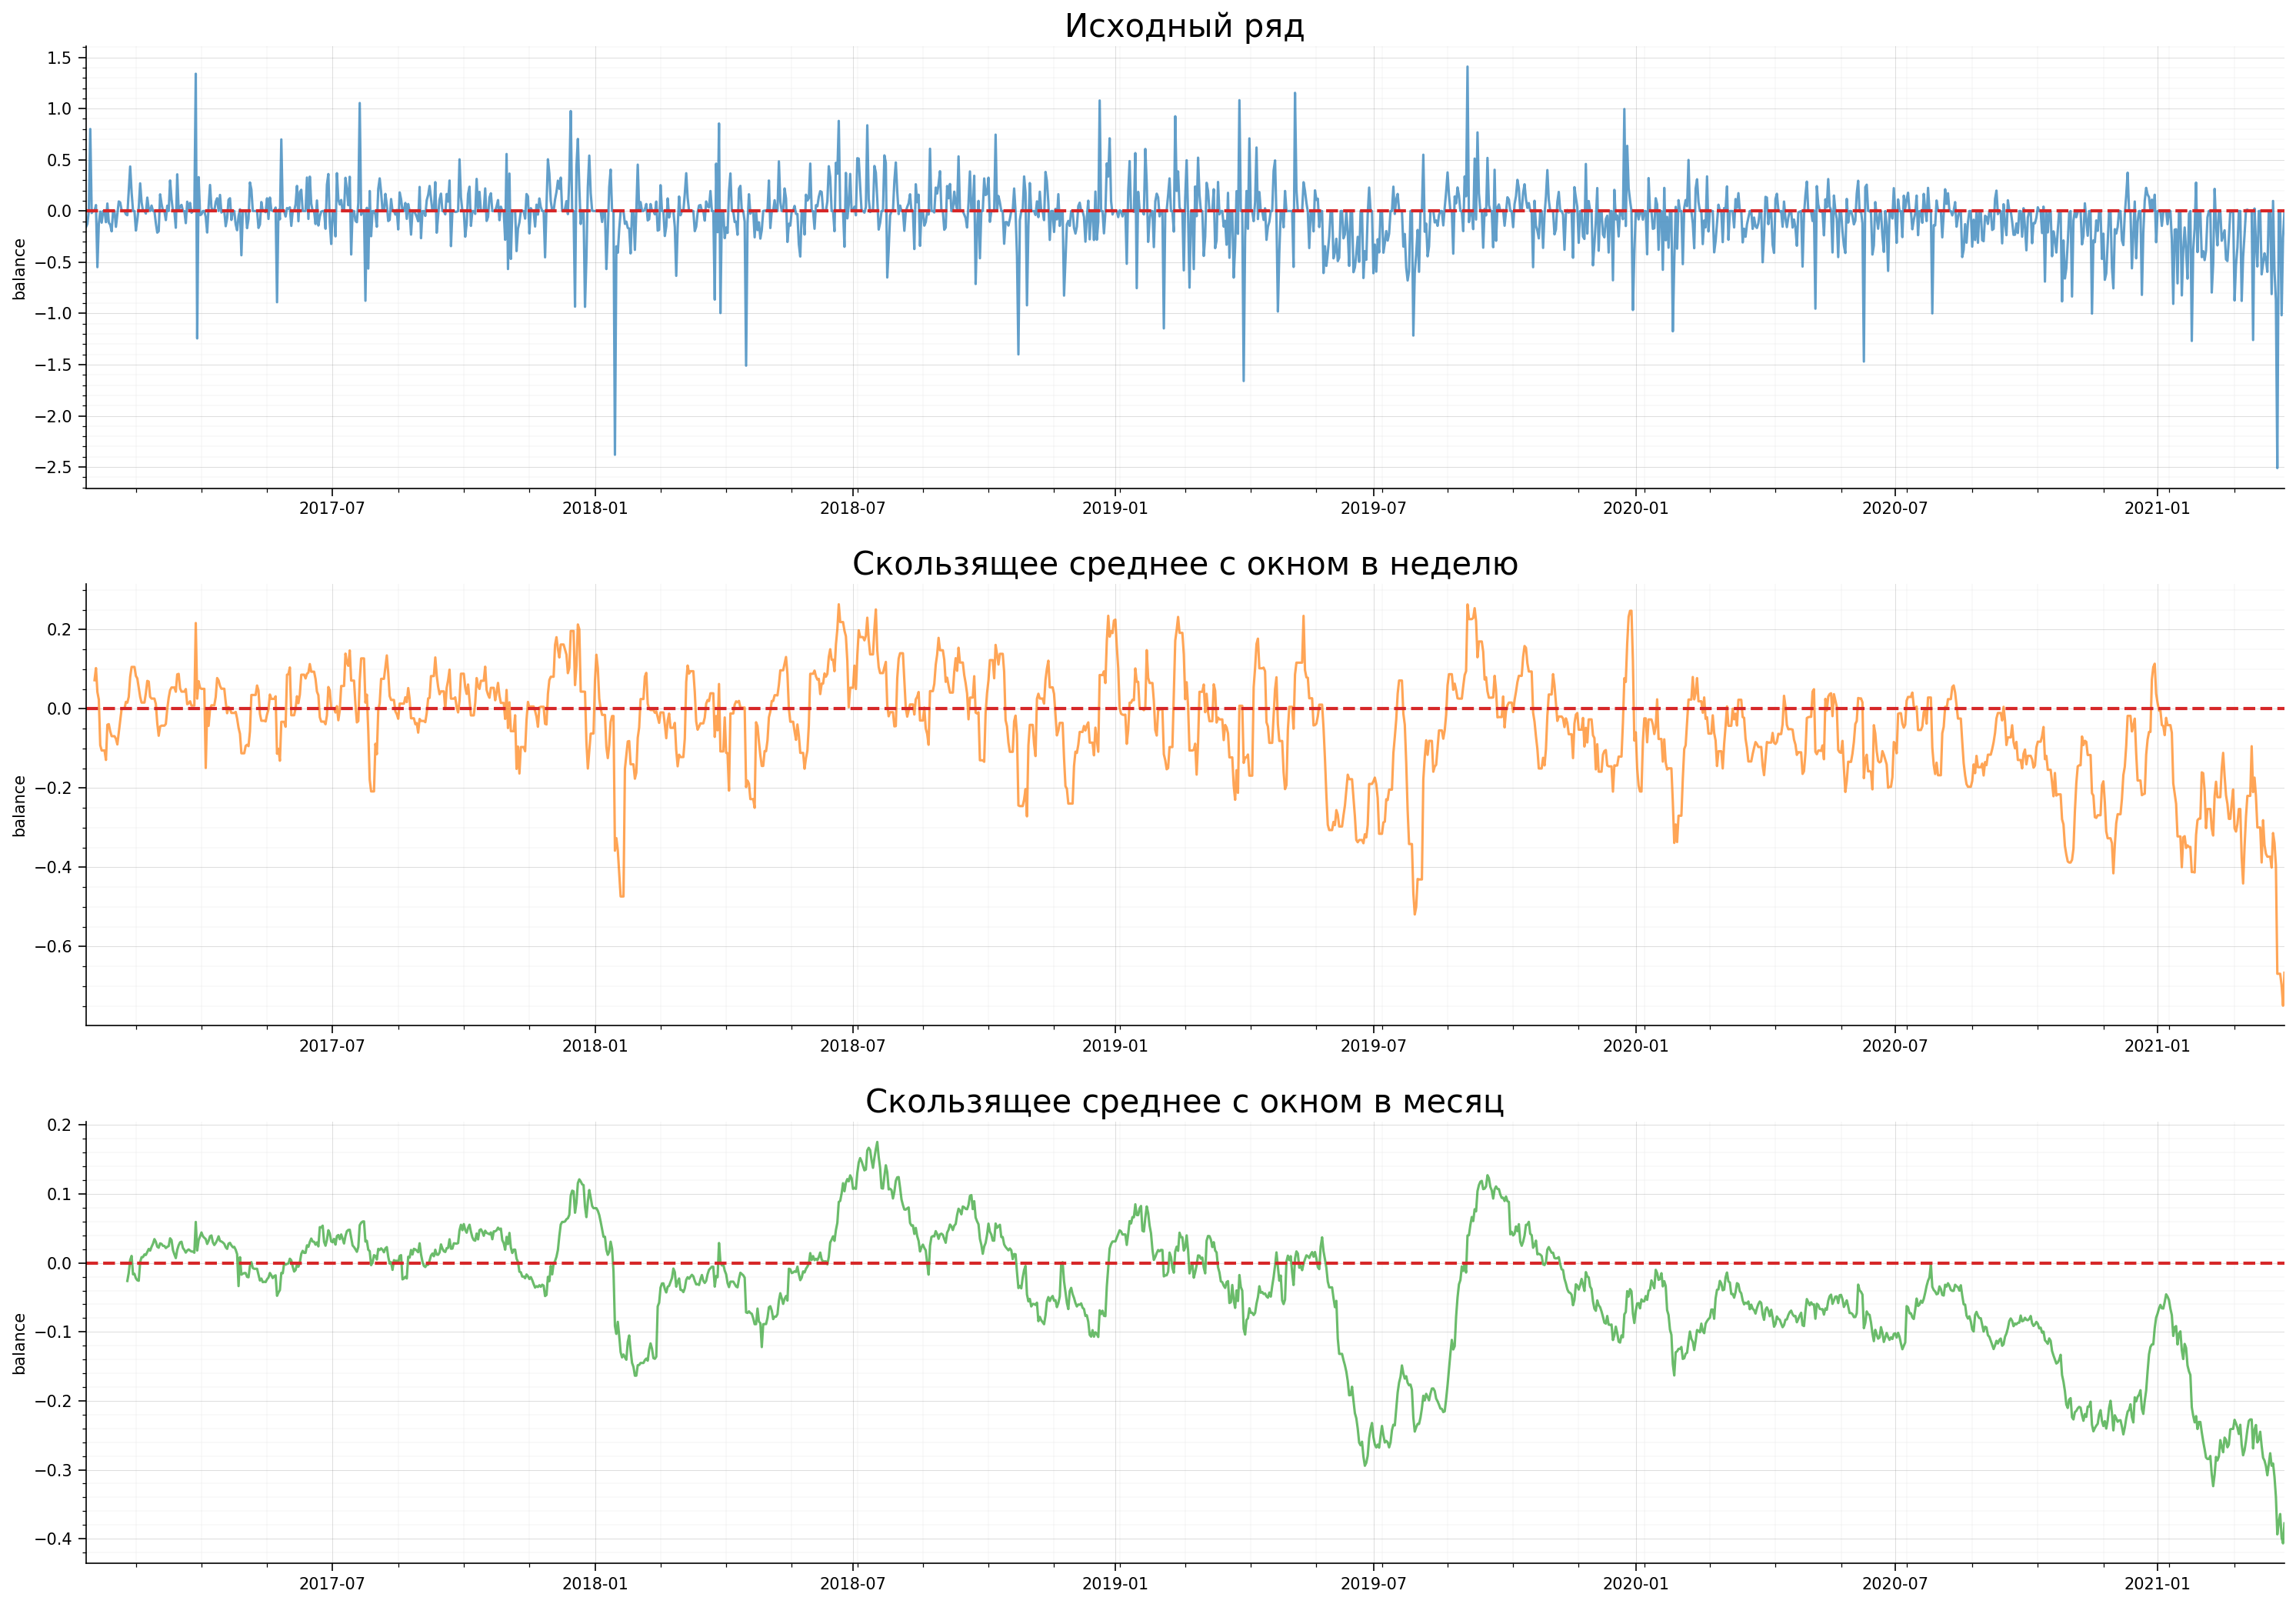

In [24]:
fig, axes = plt.subplots(figsize=(20, 14), nrows=3, dpi=150)
colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['Исходный ряд', 'Скользящее среднее с окном в неделю', 'Скользящее среднее с окном в месяц']
for ax, window, label, color in zip(axes, [0, 7, 30], labels, colors):
    if window == 0:
        df = data[['balance']]
    else:
        df = data[['balance']].rolling(window).mean()
    df = df.reset_index(names=['date'])
    sns.lineplot(
        df, x='date', y='balance',
        color=color,
        ax=ax,
        alpha=0.7
    )
    make_ax_better(ax, locators=['x', 'y'])
    ax.set_xlim(data.index.min(), data.index.max())
    ax.set_title(label, fontsize=20)
    ax.axhline(0, lw=2, ls='--', color='tab:red')
    ax.set_xlabel('')
plt.tight_layout(h_pad=2)

**Заметно, что после 2020 стало гораздо меньше положительных дней и больше отрицательных**

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



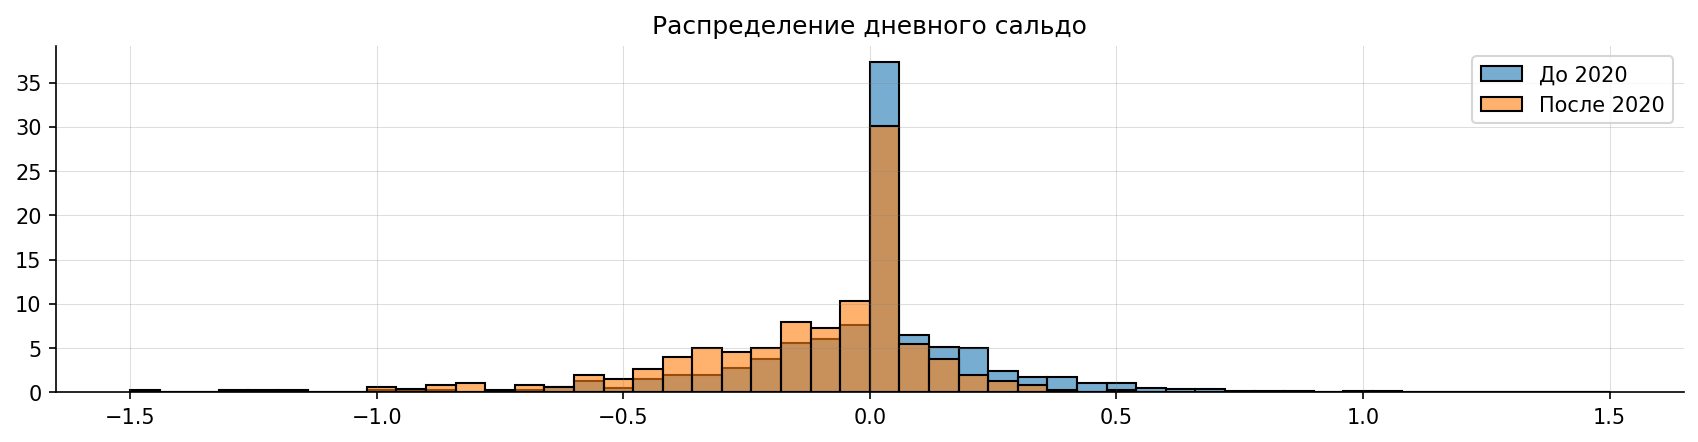

,count,mean,std,min,25%,50%,75%,max
До 2020,1087.0,-0.012,0.286,-2.38,-0.094,0.0,0.083,1.41


,count,mean,std,min,25%,50%,75%,max
После 2020,456.0,-0.137,0.288,-2.51,-0.245,-0.01,0.0,0.498


In [25]:
fig, ax = plt.subplots(figsize=(14, 3), dpi=150)
bins_kws = {
    'stat': 'percent', 'ax': ax,
    'binrange': (-1.5, 1.5),
    'bins': 50,
    'alpha': 0.6
}
s1 = data[data.index.year < 2020].balance
s2 = data[data.index.year >= 2020].balance
sns.histplot(s1, **bins_kws, label='До 2020')
sns.histplot(s2, **bins_kws, label='После 2020')
ax.set_title('Распределение дневного сальдо')
make_ax_better(ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.legend()
plt.show()
display(pd.DataFrame(s1.describe().round(3).rename('До 2020')).T)
display(pd.DataFrame(s2.describe().round(3).rename('После 2020')).T)

**Проверим стационарность по ADF до 2020 и после 2020**

In [26]:
# ADF Test
result = adfuller(s1, autolag='AIC')
print('Данные до 2020')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('\nДанные после 2020')
result = adfuller(s2, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}\n')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

Данные до 2020
ADF Statistic: -8.310292749794382
p-value: 3.8050701720563295e-13

Данные после 2020
ADF Statistic: -2.5292803618725603
p-value: 0.10851164759907111

Critial Values:
   1%, -3.445231637930579
Critial Values:
   5%, -2.8681012763264233
Critial Values:
   10%, -2.5702649212751583


Видно, что до 2020 года ряд был стационарным, а после уже перестал

## Первичные найденные особенности
1. `income` и `outcome` имеют тренд и растут с начала промежутка к концу (возможно, следствие инфляции).
2. `balance` после 2020 года в большей степени находится в отрицательной зоне и даже перестает быть стационарным (хотя ранее был). Визуально наблюдается тренд снижения сальдо с 2020 года и рост дисперсии, а по распределению сальдо видно, как его среднее смещается в отрицательную зону.
3. Разложение на компоненты оставляет достаточно закономерные ошибки в остатках, поэтому нужно смотреть на внешние факторы.

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



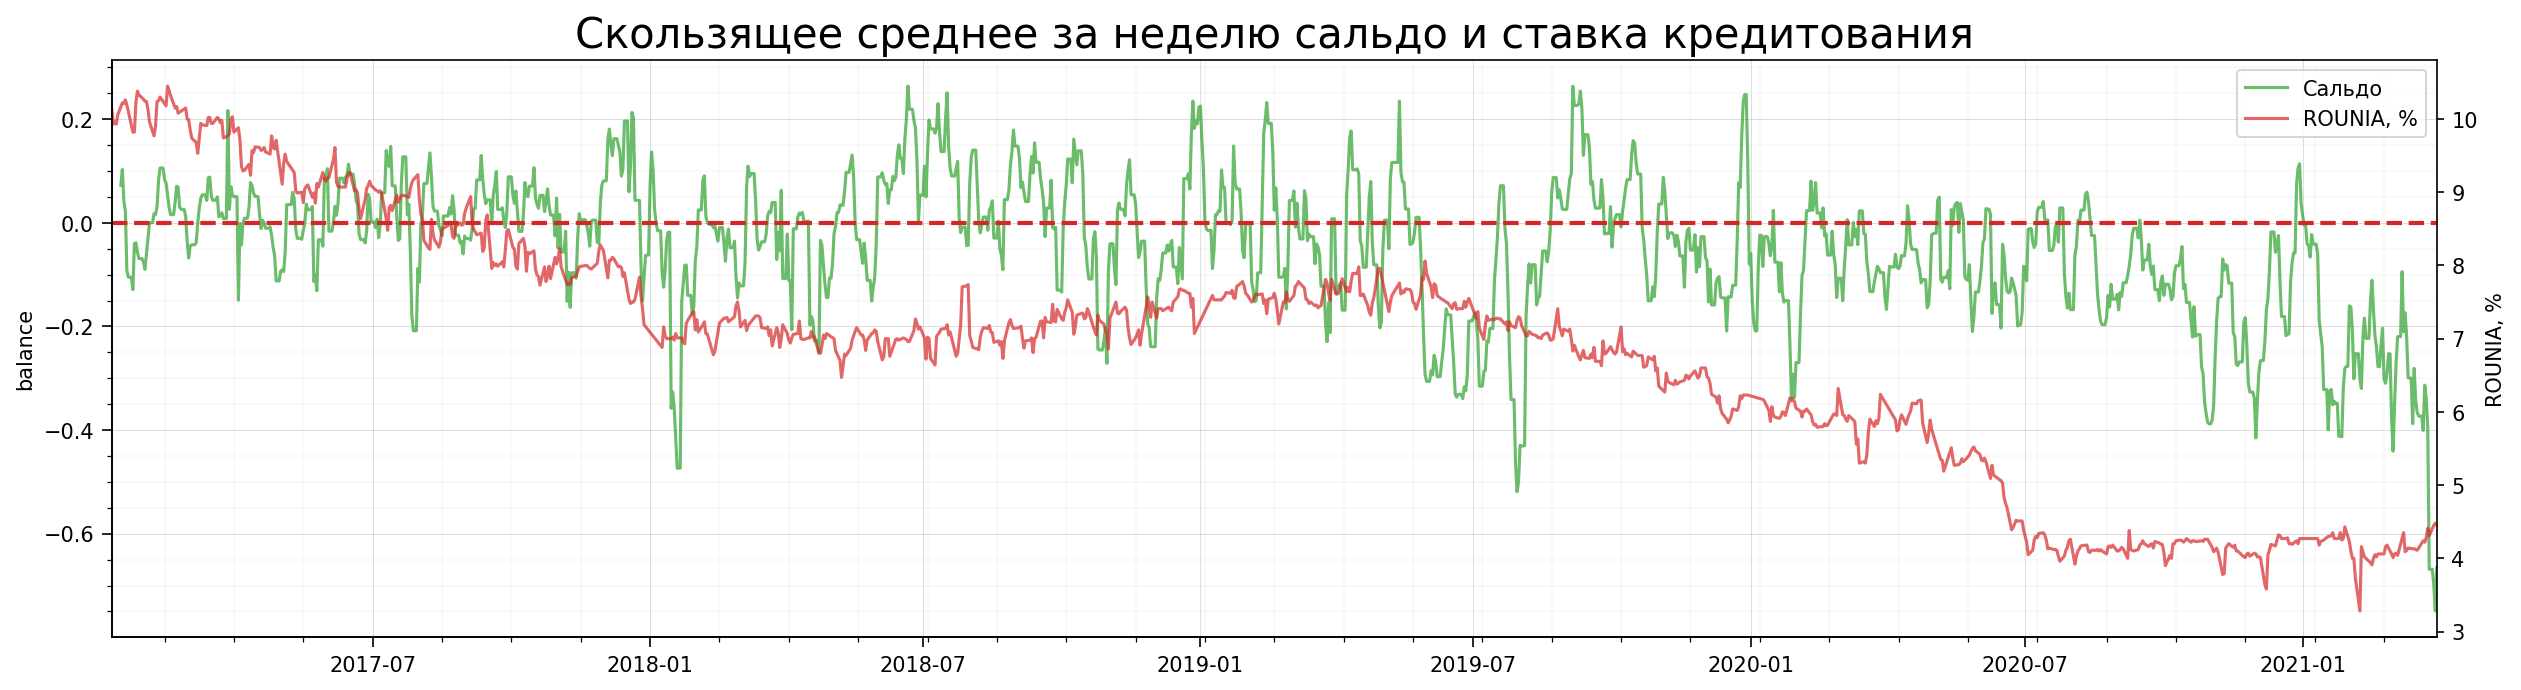

In [27]:
fig, ax = plt.subplots(figsize=(20, 5), dpi=150)
df = data[['balance']].rolling(7).mean().reset_index()
sns.lineplot(
    df, x='date', y='balance',
    color=color,
    ax=ax,
    alpha=0.7,
    label='Сальдо'
)
make_ax_better(ax, locators=['x', 'y'])
ax.set_xlim(data.index.min(), data.index.max())
ax.set_title('Скользящее среднее за неделю сальдо и ставка кредитования', fontsize=20)
ax.axhline(0, lw=2, ls='--', color='tab:red')
ax.set_xlabel('')
h1, l1 = ax.get_legend_handles_labels()
rate_ax = ax.twinx()
sns.lineplot(
    rate_df.reset_index(), x='date', y='rate',
    color='tab:red',
    ax=rate_ax,
    alpha=0.7,
    label='ROUNIA, %'
)
h2, l2 = rate_ax.get_legend_handles_labels()
ax.legend(
    h1+h2, l1+l2
)
rate_ax.set_ylabel('ROUNIA, %')
rate_ax.get_legend().remove()
rate_ax.set_xlabel('')
plt.show()

**В целом видно, что ставка в 2019-2020 году шла по траектории снижения, поэтому, вероятно, могли быть оттоки с банковских депозитов на более доходные инструменты (фондовый рынок) и, например, на потребление, что для банка выражалось в отрицательном сальдо, однако напрямую эти данные вряд ли получится использовать.**

Еще интересно, что резкие пики по сальдо приводили к скачам RUONIA впоследствии, посмотрим на это детальнее.

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\ilya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



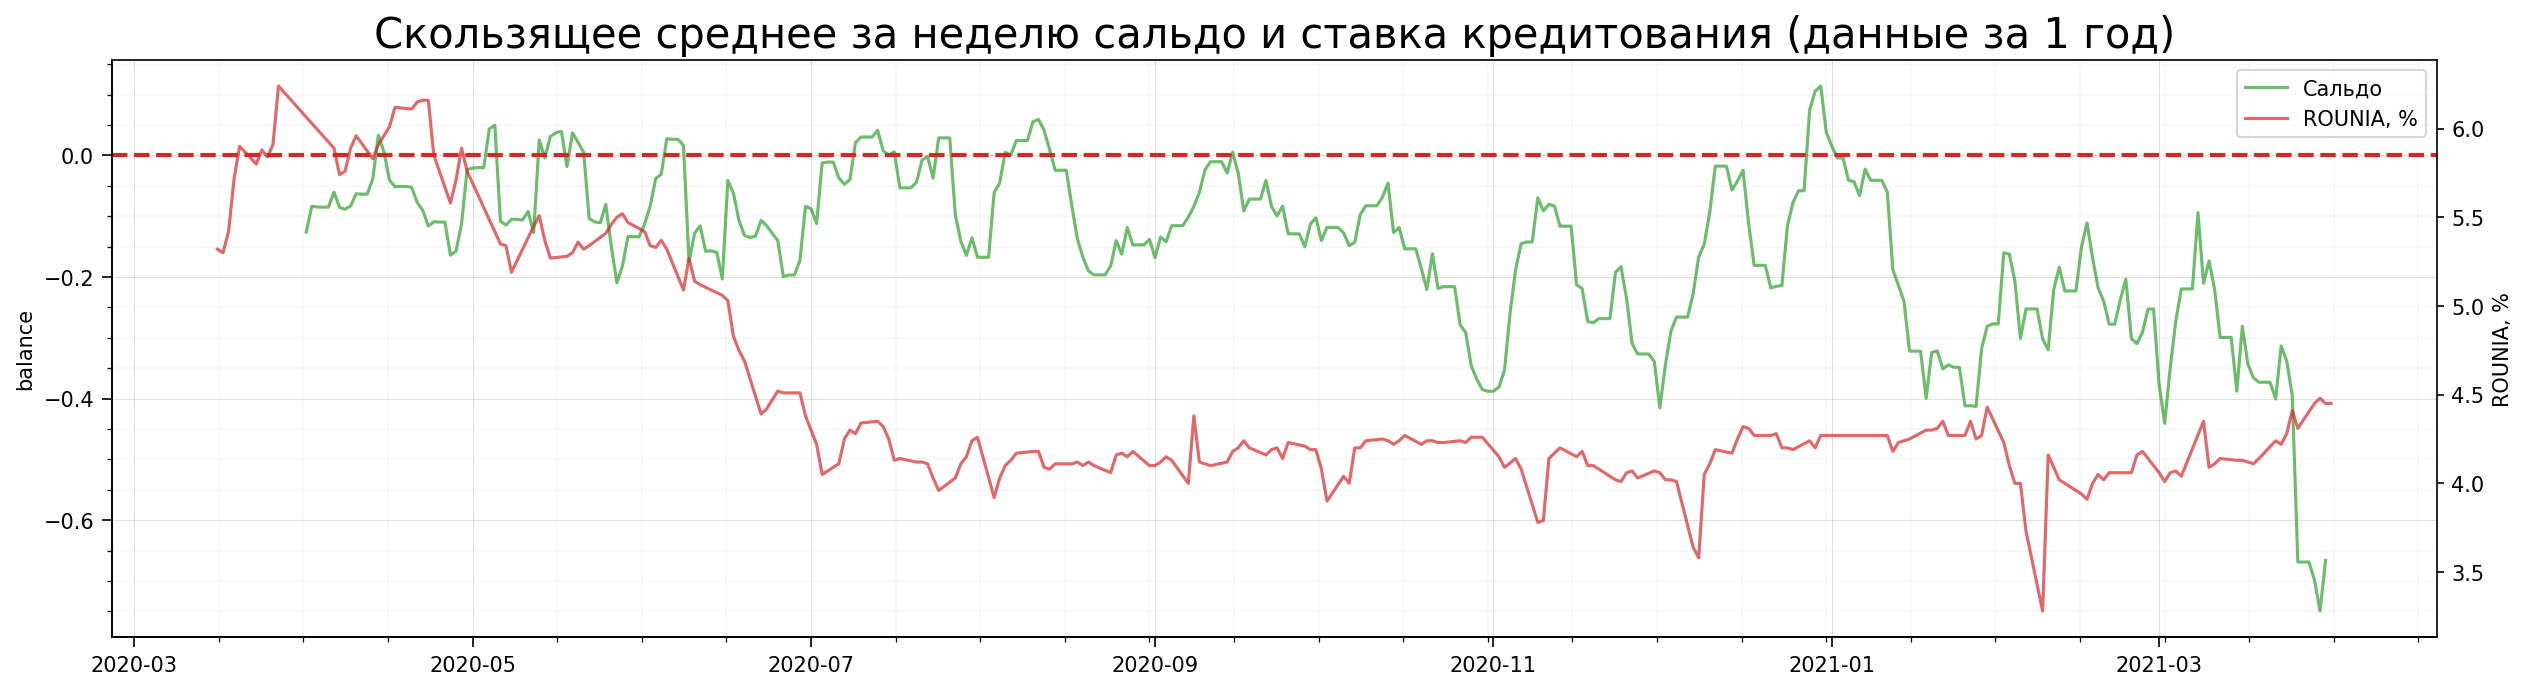

In [28]:
fig, ax = plt.subplots(figsize=(20, 5), dpi=150)
df = data[['balance']].rolling(7).mean().reset_index().tail(365)
sns.lineplot(
    df, x='date', y='balance',
    color=color,
    ax=ax,
    alpha=0.7,
    label='Сальдо'
)
make_ax_better(ax, locators=['x', 'y'])
ax.set_title('Скользящее среднее за неделю сальдо и ставка кредитования (данные за 1 год)', fontsize=20)
ax.axhline(0, lw=2, ls='--', color='tab:red')
ax.set_xlabel('')
h1, l1 = ax.get_legend_handles_labels()
rate_ax = ax.twinx()
sns.lineplot(
    rate_df.reset_index().tail(252), x='date', y='rate',
    color='tab:red',
    ax=rate_ax,
    alpha=0.7,
    label='ROUNIA, %'
)
h2, l2 = rate_ax.get_legend_handles_labels()
ax.legend(
    h1+h2, l1+l2
)
rate_ax.set_ylabel('ROUNIA, %')
rate_ax.get_legend().remove()
rate_ax.set_xlabel('')
plt.show()

Видно, как за резким снижением сальдо следовало с задержкой снижение ставки в некоторых моментах

**Исходя из ранее отмеченных предпосылок рассмотрим детальнее данные после 2020 года**

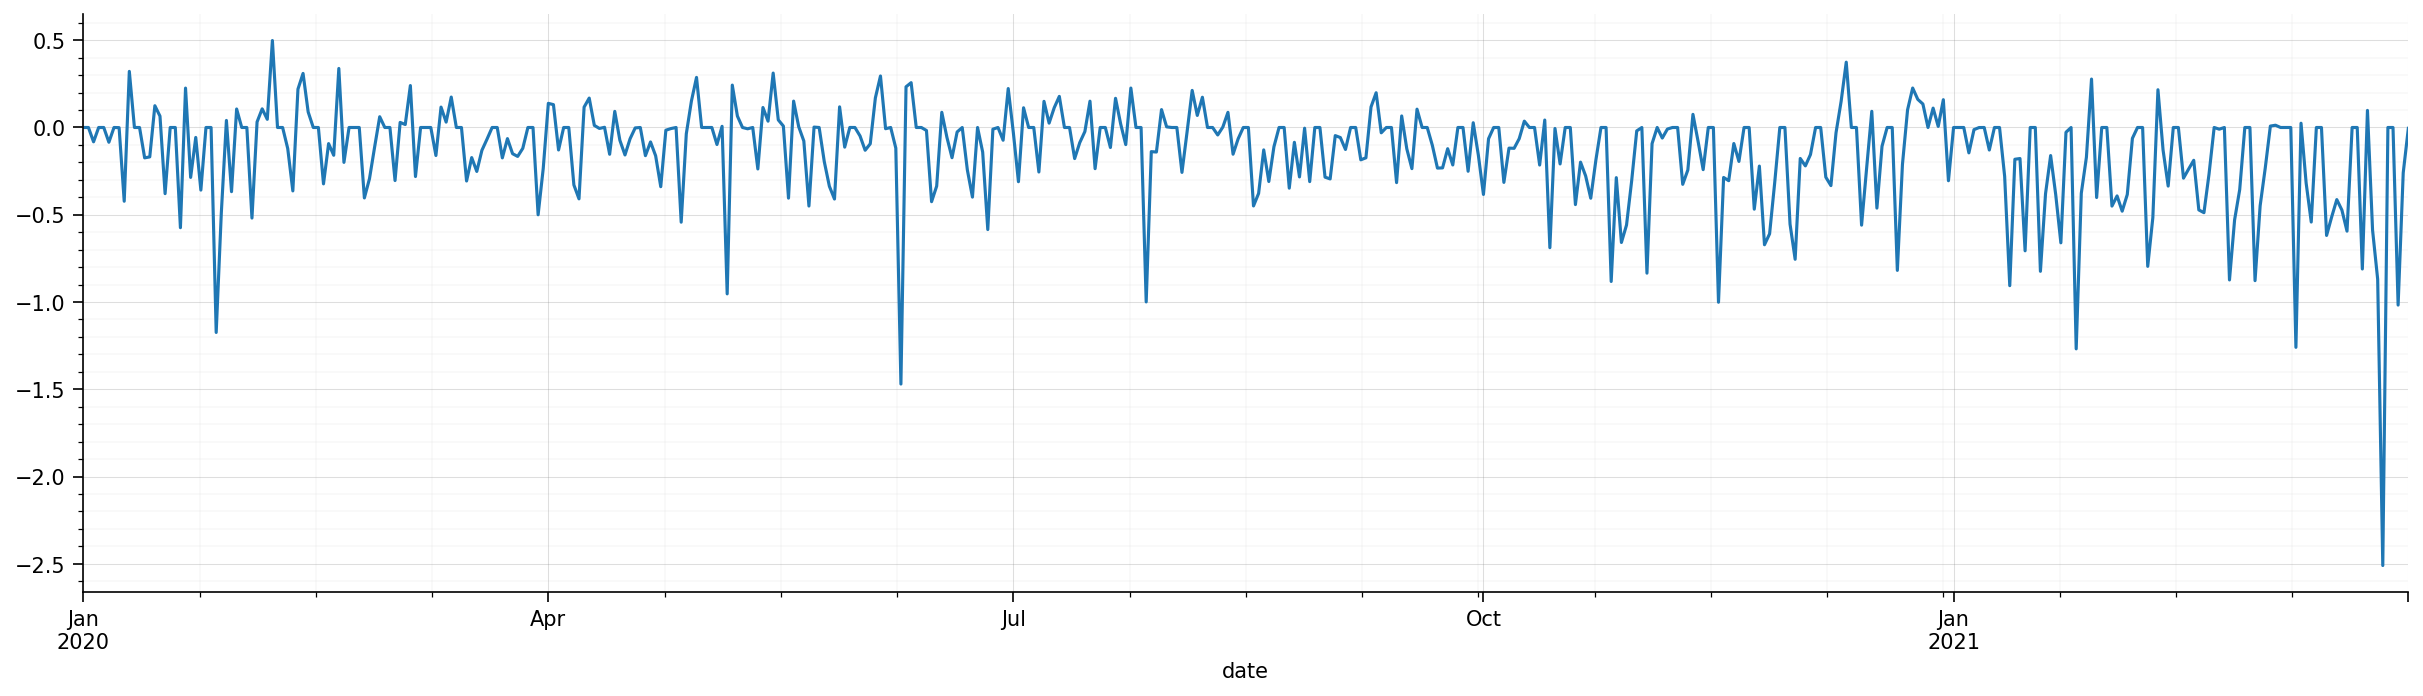

In [29]:
clear_data = data[data.index.year >= 2020].copy()
fig, ax = plt.subplots(figsize=(20, 5), dpi=150)
clear_data.balance.plot(ax=ax)
make_ax_better(ax, locators=['x', 'y'])

Сразу отметим, что наблюдается что-то странное в конце промежутка (очень большой отток, причина которого пока не ясна)

In [30]:
clear_data[-8:-3]

,income,outcome,balance
date,,,
2021-03-24,1.94,2.53,-0.587778
2021-03-25,2.30,3.17,-0.869810
2021-03-26,2.17,4.69,-2.510000
2021-03-27,0.00,0.00,0.000000
2021-03-28,0.00,0.00,0.000000


Вероятно, судя по графикам и дате, в этот день произошла крупная выплата налога.

Ну, или...

<img src='attachment:e022477d-489a-44da-a47d-1bc7a920fa53.png' width=700></img>

Посмотрим на нули в данных

In [31]:
values_by_sign = clear_data.copy()
values_by_sign['flag'] = values_by_sign['balance'].apply(
    func=lambda x: 0 if x == 0 else (1 if x > 0 else (2 if x < 0 else np.nan))
)
pd.concat([
    values_by_sign['flag'].value_counts(),
    values_by_sign['flag'].value_counts(normalize=True)*100,
], axis=1)

,count,proportion
flag,,
2,256,56.140351
0,111,24.342105
1,89,19.517544


24% данных это нули, при этом в 19.5% значения больше нуля, а в 56% дней меньше нуля. Посмотрим на причину нулей.

In [32]:
values_by_sign[values_by_sign['flag']==0].index.dayofweek.value_counts()

date
6    57
5    45
2     3
4     3
1     2
3     1
Name: count, dtype: int64

В большинстве своем нули на выходных, однако есть нули и в другие дни, и, кроме того, вероятно, что если у нас выходной, то это не значит, что будет нулевое сальдо

In [33]:
weekdays_data = clear_data.reset_index().copy()
weekdays_data['is_holiday'] = weekdays_data['date'].isin(holidays['holidays'])
weekdays_data['is_nowork'] = weekdays_data['date'].isin(holidays['nowork'])
weekdays_data['dayofweek'] = weekdays_data['date'].dt.dayofweek
weekdays_data.groupby(['dayofweek', 'is_holiday', 'is_nowork'])['balance'].describe()

count      mean       std       min       25%  \
dayofweek is_holiday is_nowork                                                  
0         False      False       52.0 -0.438192  0.321565 -1.268604 -0.585338   
                     True         5.0 -0.337385  0.182710 -0.542662 -0.500265   
          True       False        8.0 -0.042156  0.058171 -0.145435 -0.087801   
1         False      False       56.0 -0.237236  0.315035 -1.470000 -0.366815   
                     True         5.0 -0.134236  0.193194 -0.408989 -0.235376   
          True       False        4.0 -0.001345  0.007902 -0.012179 -0.003045   
2         False      False       54.0 -0.125936  0.253519 -0.873672 -0.246804   
                     True         7.0 -0.111769  0.389235 -0.953475 -0.117703   
          True       False        5.0 -0.006042  0.012861 -0.029040 -0.000828   
3         False      False       57.0 -0.121022  0.260412 -0.869810 -0.310758   
                     True         6.0  0.055505  0.248341 -0.339241 -0.085235   
          True       False        2.0 -0.000010  0.000014 -0.000020 -0.000015   
4         False      False       55.0 -0.164068  0.421128 -2.510000 -0.313004   
                     True         5.0 -0.026249  0.074127 -0.128825 -0.064412   
          True       False        5.0 -0.042225  0.060164 -0.129086 -0.082038   
5         False      False        1.0 -0.266053       NaN -0.266053 -0.266053   
          True       False       64.0  0.001213  0.018652 -0.027359  0.000000   
6         True       False       65.0 -0.000238  0.002542 -0.017241  0.000000   

                                     50%       75%           max  
dayofweek is_holiday is_nowork                                    
0         False      False     -0.319524 -0.210214  1.110426e-01  
                     True      -0.329129 -0.161410 -1.534603e-01  
          True       False     -0.004867 -0.000007 -4.608431e-09  
1         False      False     -0.216313 -0.054176  2.258344e-01  
                     True      -0.082896 -0.036284  9.236324e-02  
          True       False      0.000000  0.001700  6.798414e-03  
2         False      False     -0.120690  0.083994  2.331369e-01  
                     True       0.000000  0.127601  1.512980e-01  
          True       False     -0.000342  0.000000  0.000000e+00  
3         False      False     -0.091844  0.065129  3.383190e-01  
                     True       0.149735  0.224378  2.871016e-01  
          True       False     -0.000010 -0.000005  0.000000e+00  
4         False      False     -0.119412  0.075294  4.984655e-01  
                     True      -0.015557  0.012027  6.552262e-02  
          True       False      0.000000  0.000000  0.000000e+00  
5         False      False     -0.266053 -0.266053 -2.660526e-01  
          True       False      0.000000  0.000000  1.345602e-01  
6         True       False      0.000000  0.000000  8.004304e-03

Как и предполагалось, даже в выходные бывают перетоки, что, с одной стороны, странно, но в целом, наверное, имеет какой-то смысл

**Как мы помним, ряд после 2020 года на уровнях значимости 0.05 и 0.1 не стационарен, поэтому перейдем к разностям**

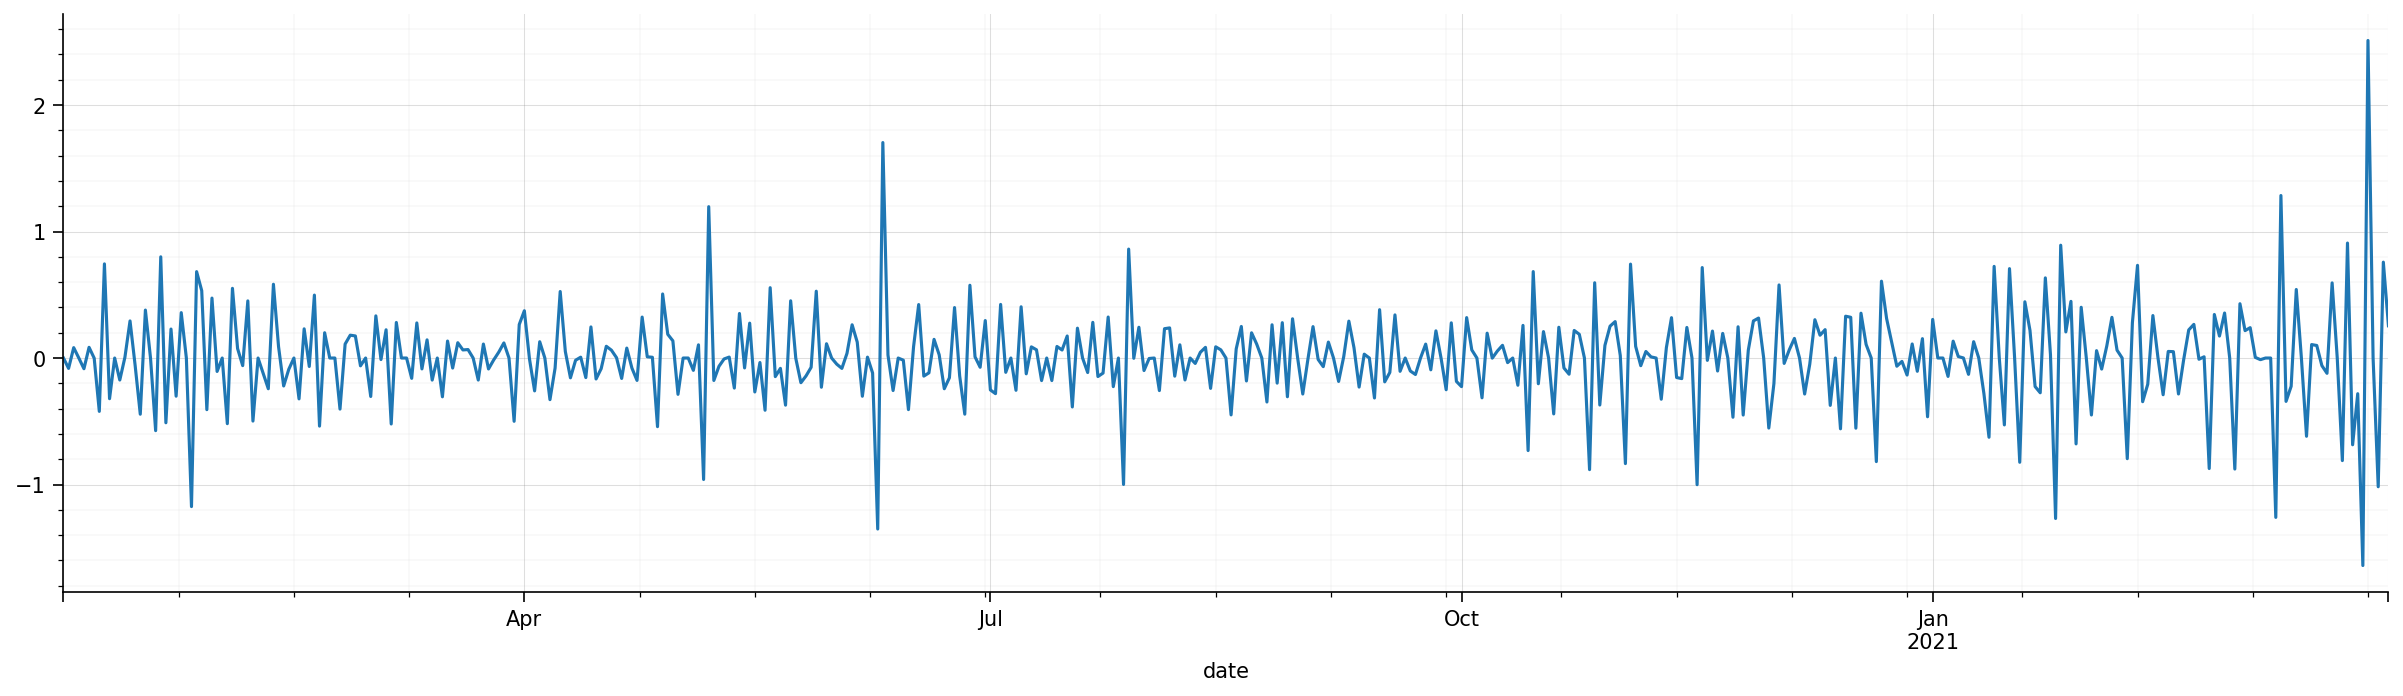

In [34]:
clear_data_diff = clear_data.diff().dropna()
fig, ax = plt.subplots(figsize=(20, 5), dpi=150)
clear_data_diff.balance.plot(ax=ax)
make_ax_better(ax, locators=['x', 'y'])

In [35]:
result = adfuller(clear_data_diff.balance, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -9.552603335695983
p-value: 2.5481185631103787e-16
Critial Values:
   1%, -3.445231637930579
Critial Values:
   5%, -2.8681012763264233
Critial Values:
   10%, -2.5702649212751583


Исходя из дисперсии, даже несмотря на результаты теста видно, что ее тяжело назвать постоянной, но придется с этим жить

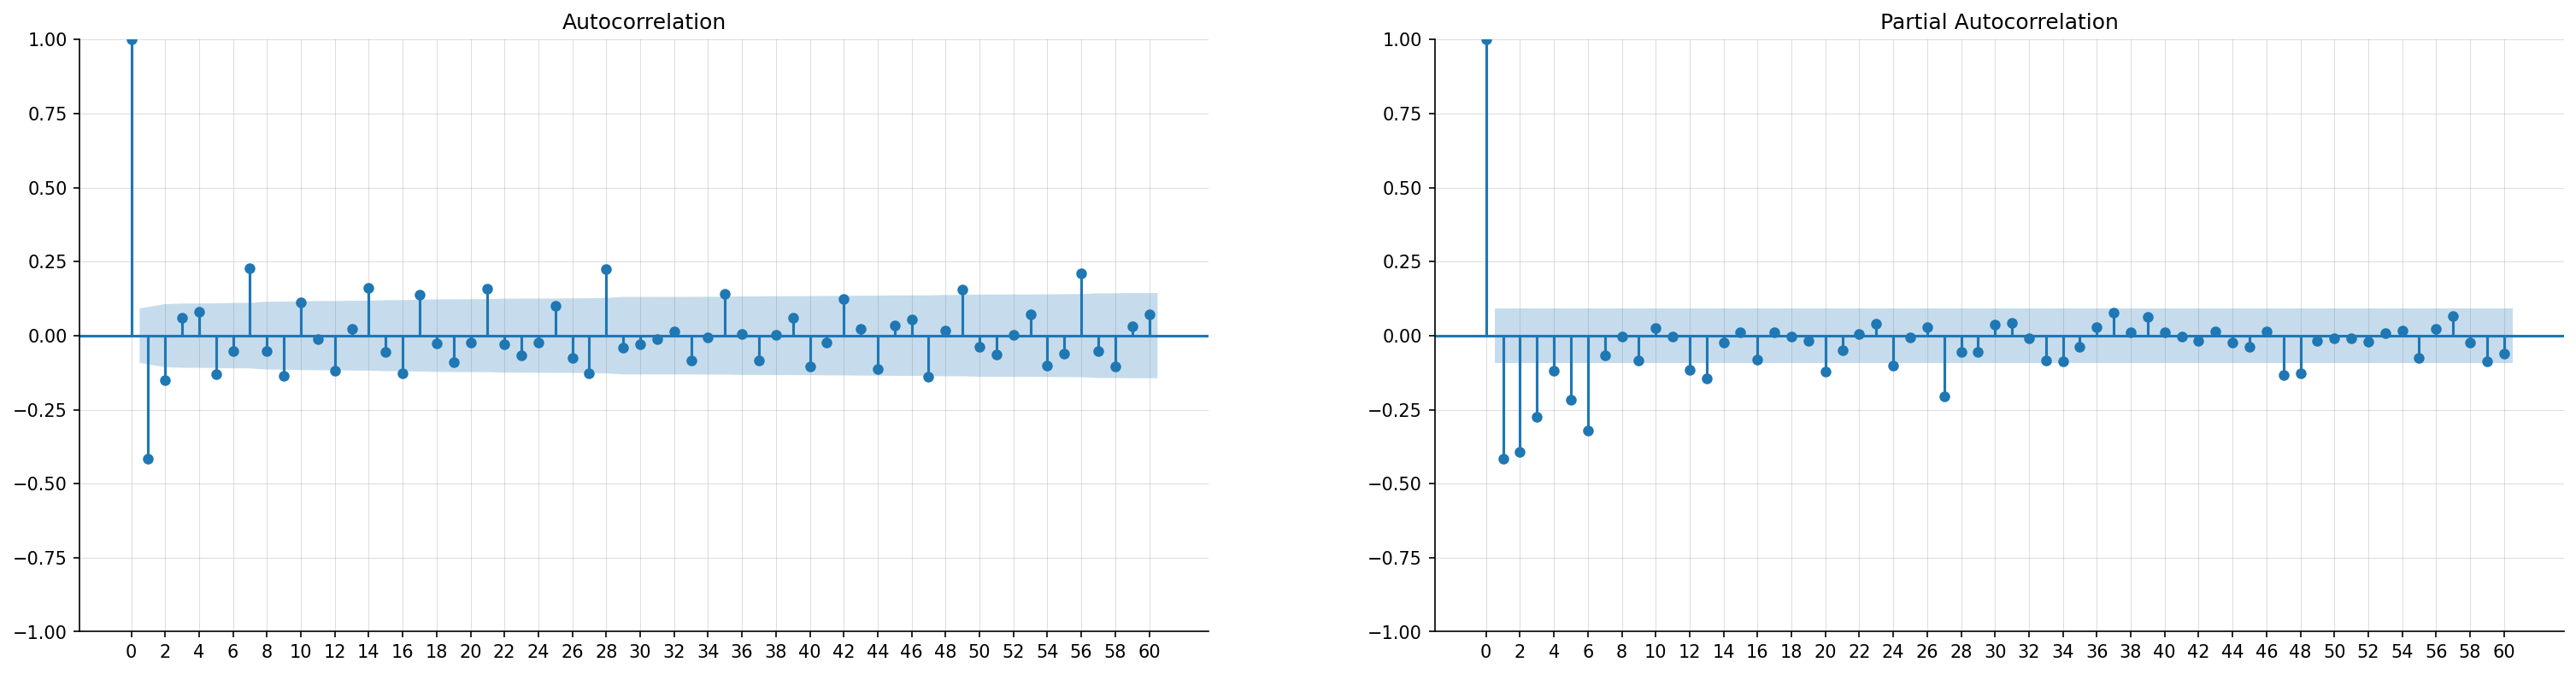

In [36]:
fig, axes = plt.subplots(figsize=(25, 6), dpi=150, ncols=2)
plot_acf(clear_data_diff.balance.values, ax=axes[0], lags=60)
plot_pacf(clear_data_diff.balance.values, ax=axes[1], lags=60)
for ax in axes:
    make_ax_better(ax)
    ax.set_xticks([i for i in range(0, 61, 2)])
plt.show()

В целом видно, что есть автокорреляции, причем отрицательные в большей степени

# Сбор модели

In [37]:
data = clear_data[['balance']].reset_index()
train_df = data[:-28].copy()
test_df = data[-28:].copy()
model = BaselineModel(
    cross_val_split_kws = {'test_size_weeks': 1, 'train_size_weeks': 32},
    hyperparams_optimizer_kws = {'optuna_n_trials': 1}
)
model.fit(df=train_df, taxes=taxes, holidays=holidays)

[I 2025-04-27 12:46:55,986] A new study created in memory with name: no-name-05bba249-32fe-4eb2-a31b-cc3f34cb8c90
[I 2025-04-27 12:47:58,791] Trial 0 finished with value: 0.00810337272612012 and parameters: {'iterations': 1722, 'learning_rate': 0.003812082935274452, 'depth': 4, 'l2_leaf_reg': 0.004464783191464654, 'random_strength': 2.3943413407079945, 'bagging_temperature': 1.906714666663795, 'max_ctr_complexity': 3}. Best is trial 0 with value: 0.00810337272612012.


In [38]:
model.mean_metrics

{'mae': 0.13127214535267145,
 'max_ae': 0.43366653707007385,
 'target_loss': 0.007752820851630021}

In [39]:
forecast = model.forecast(df=data, taxes=taxes, holidays=holidays)
forecast.tail()

date
2021-03-27   -0.031467
2021-03-28   -0.029233
2021-03-29   -0.282175
2021-03-30   -0.217451
2021-03-31   -0.242670
dtype: float64

In [40]:
eval_df = pd.concat([
    forecast.rename('y_pred'),
    data.set_index('date')['balance'].rename('y_true')
], axis=1).dropna() # оставляем только валидный промежуток
eval_df.tail()

,y_pred,y_true
date,,
2021-03-27,-0.031467,0.000000
2021-03-28,-0.029233,0.000000
2021-03-29,-0.282175,-1.017679
2021-03-30,-0.217451,-0.259687
2021-03-31,-0.242670,-0.004878


In [41]:
colors = ['#F75C03', '#00CC66']
print('Прерывистой линией отмечено начало тестового промежутка, который не участвовал в обучении')
plot_ts_plotly(
    [eval_df['y_pred'], eval_df['y_true']],
    title='Сравнение предсказания и реальности', 
    colors=colors, v_lines=[{'x': test_df.date.min(), 'label': 'Начало тестового промежутка'}]
)

Прерывистой линией отмечено начало тестового промежутка, который не участвовал в обучении


In [42]:
model.selected_features

['balance__lag_7',
 'balance__lag_8',
 'balance__lag_9',
 'balance__lag_10',
 'balance__lag_11',
 'balance__lag_12',
 'balance__lag_13',
 'balance__lag_14',
 'balance__lag_15',
 'balance__lag_16',
 'balance__lag_17',
 'balance__lag_18',
 'balance__lag_19',
 'balance__lag_20',
 'balance__lag_21',
 'balance__lag_22',
 'balance__lag_23',
 'balance__lag_24',
 'balance__lag_25',
 'balance__lag_26',
 'balance__lag_27',
 'balance__lag_28',
 'balance__lag_29',
 'balance__lag_30',
 'day_of_week',
 'day_of_month',
 'month',
 'is_holiday',
 'tax_type_Налог на добавленную стоимость (НДС)',
 'tax_type_Налог на доходы физических лиц (НДФЛ)',
 'tax_type_Торговый сбор',
 'tax_type_Упрощенная система налогообложения (УСН)',
 'tax_type_Участникам ЕГАИС и другим плательщикам акцизов',
 'tax_type_Пользователям недр',
 'tax_type_Страховые взносы',
 'is_after_25_day',
 'is_nowork',
 'tax_type_Годовая бухгалтерская (финансовая) отчетность, аудиторское заключение',
 'tax_type_Система налогообложения в виде ед

In [43]:
data = clear_data[['balance']].reset_index()
train_df = data[:-28].copy()
test_df = data[-28:].copy()
model = BaselineModel(
    cross_val_split_kws = {'test_size_weeks': 1, 'train_size_weeks': 32},
    hyperparams_optimizer_kws = {'optuna_n_trials': 1},
    feature_selector_kws={'threshold': '0.5*median'}
)
model.fit(df=train_df, taxes=taxes, holidays=holidays)

[I 2025-04-27 12:48:10,842] A new study created in memory with name: no-name-9e2fb85f-ebeb-4467-901d-8998e6288c4c
[I 2025-04-27 12:48:30,131] Trial 0 finished with value: 0.00936756099578612 and parameters: {'iterations': 989, 'learning_rate': 0.0037649097046311424, 'depth': 2, 'l2_leaf_reg': 2.5746787712390344, 'random_strength': 3.8337834680594916, 'bagging_temperature': 0.5655923924631185, 'max_ctr_complexity': 2}. Best is trial 0 with value: 0.00936756099578612.


In [44]:
forecast = model.forecast(df=data, taxes=taxes, holidays=holidays)
eval_df = pd.concat([
    forecast.rename('y_pred'),
    data.set_index('date')['balance'].rename('y_true')
], axis=1).dropna() # оставляем только валидный промежуток
print('Прерывистой линией отмечено начало тестового промежутка, который не участвовал в обучении')
plot_ts_plotly(
    [eval_df['y_pred'], eval_df['y_true']],
    title='Сравнение предсказания и реальности', 
    colors=colors, v_lines=[{'x': test_df.date.min(), 'label': 'Начало тестового промежутка'}]
)
model.mean_metrics

Прерывистой линией отмечено начало тестового промежутка, который не участвовал в обучении


{'mae': 0.1490979350524329,
 'max_ae': 0.4652812579509402,
 'target_loss': 0.009119473224831313}

In [45]:
colors = ['#F75C03', '#00CC66']
print('Прерывистой линией отмечено начало тестового промежутка, который не участвовал в обучении')
plot_ts_plotly(
    [(eval_df['y_pred']-eval_df['y_true']).rename('diff')],
    title='Разность предсказания и реальности', 
    colors=colors, v_lines=[{'x': test_df.date.min(), 'label': 'Начало тестового промежутка'}]
)

Прерывистой линией отмечено начало тестового промежутка, который не участвовал в обучении


### Сравнение методов (CatBoost (встроенный), RFE (оберточный), Mutual Information (фильтрационный))

In [ ]:
# Импортируем нужные библиотеки и реализовальный модуль Feature_selection

from src.feature_selection import selectors
from sklearn.metrics import jaccard_score
import time
from scipy.stats import pearsonr
from itertools import combinations
from scipy.stats import entropy
from itertools import islice

In [ ]:
# Получим из нашей модели данные и фичи
model = BaselineModel(
    hyperparams_optimizer_kws = {'optuna_n_trials': 1}
)
X, y  = model.prepare_data(df=data, taxes=taxes, holidays=holidays)

In [ ]:
embedded_selector = selectors.SelectFromModelEmbeddedFeatureSelector()
wrapper_selector = selectors.WrapperFeatureSelector()
filter_selector = selectors.FilterFeatureSelector()

In [ ]:
import time
from sklearn.metrics import jaccard_score
import numpy as np
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import entropy
from itertools import islice

embedded_selector = selectors.SelectFromModelEmbeddedFeatureSelector()
wrapper_selector = selectors.WrapperFeatureSelector()
filter_selector = selectors.FilterFeatureSelector()

tscv = TimeSeriesSplit(n_splits=5, test_size= 7)

stability_results = {
    "embedded": {"masks": [], "time": []},
    "wrapper": {"masks": [], "time": []},
    "filter": {"masks": [], "time": []}
}


def overlap_coefficient(masks):
    """Коэффициент перекрытия между всеми парами фолдов"""
    pairs = list(combinations(masks, 2))
    overlap_scores = []
    for a, b in pairs:
        intersection = np.sum(a & b)
        min_size = min(np.sum(a), np.sum(b))
        overlap_scores.append(intersection / min_size if min_size > 0 else 0)
    return np.mean(overlap_scores)

def exact_match_percentage(masks):
    """Доля полностью совпадающих пар фолдов"""
    pairs = list(combinations(masks, 2))
    return np.mean([np.array_equal(a, b) for a, b in pairs])

def fleiss_kappa(masks):
    n_folds, n_features = masks.shape
    p = np.mean(masks, axis=0)
    P_e = np.sum(p**2 + (1 - p)**2) / n_features
    p_j = (np.sum(masks, axis=0) * (np.sum(masks, axis=0) - 1)).sum() 
    p_j /= n_folds * (n_folds - 1) * n_features
    return (p_j - P_e) / (1 - P_e) if P_e != 1 else 0.0

def diversity_index(masks):
    """Индекс разнообразия на основе энтропии"""
    selection_freq = np.mean(masks, axis=0)
    return entropy(selection_freq)/np.log(len(selection_freq))

def dice_coefficient(masks):
    """Средний коэффициент Dice для всех пар"""
    pairs = list(combinations(masks, 2))
    dice_scores = []
    for a, b in pairs:
        intersection = np.sum(a & b)
        dice = 2*intersection / (np.sum(a) + np.sum(b)) if (np.sum(a) + np.sum(b)) > 0 else 0
        dice_scores.append(dice)
    return np.mean(dice_scores)

# Новые метрики стабильности
def pairwise_jaccard(masks):
    pairs = list(combinations(masks, 2))
    return np.mean([jaccard_score(a, b) for a, b in pairs])

def feature_consistency(masks):
    return np.mean(np.sum(masks, axis=0) / len(masks))

def pearson_correlation(masks):
    pairs = list(combinations(masks, 2))
    return np.mean([pearsonr(a, b)[0] for a, b in pairs])

def hamming_distance(masks):
    pairs = list(combinations(masks, 2))
    return np.mean([np.mean(a != b) for a, b in pairs])

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Замер времени для каждого метода
    for method in ['embedded', 'wrapper', 'filter']:
        start_time = time.perf_counter()
        
        if method == 'embedded':
            feats = embedded_selector.select_features(X_train, y_train)
        elif method == 'wrapper':
            feats = wrapper_selector.select_features(X_train, y_train)
        else:
            feats = filter_selector.select_features(X_train, y_train)
            
        exec_time = time.perf_counter() - start_time
        mask = X.columns.isin(feats).astype(int)
        
        stability_results[method]['masks'].append(mask)
        stability_results[method]['time'].append(exec_time)


######
def temporal_window(sequence, window=2):
    """Генератор скользящих окон"""
    it = iter(sequence)
    result = tuple(islice(it, window))
    if len(result) == window:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

# Основные метрики с временной адаптацией
def temporal_pairwise_jaccard(masks):
    """Jaccard для соседних временных фолдов"""
    scores = []
    for i in range(1, len(masks)):
        scores.append(jaccard_score(masks[i-1], masks[i]))
    return np.mean(scores) if scores else 0.0

def weighted_hamming(masks, decay=0.8):
    """Взвешенное расстояние Хэмминга с экспоненциальным затуханием"""
    total = 0.0
    weight_sum = 0.0
    n = len(masks)
    for i in range(n):
        for j in range(i+1, n):
            distance = j - i
            weight = decay ** distance
            total += np.mean(masks[i] != masks[j]) * weight
            weight_sum += weight
    return total / weight_sum if weight_sum > 0 else 0.0

def temporal_feature_consistency(masks):
    """Согласованность с учетом временных тенденций"""
    trends = []
    for feature_idx in range(masks[0].shape[0]):
        selection_sequence = [mask[feature_idx] for mask in masks]
        trend_score = np.mean(np.diff(selection_sequence) == 0)
        trends.append(trend_score)
    return np.mean(trends)

def rolling_fleiss_kappa(masks, window=3):
    """Скользящее окно для Kappa"""
    kappas = []
    for window_masks in temporal_window(masks, window):
        kappas.append(fleiss_kappa(np.array(window_masks)))
    return np.mean(kappas)

# Обновленные версии исходных метрик
def temporal_fleiss_kappa(masks):
    """Временная адаптация Kappa"""
    n = len(masks)
    p = np.mean(masks, axis=0)
    P_e = np.sum(p**2 + (1 - p)**2) / masks.shape[1]
    
    total = 0
    for i in range(n-1):
        agreement = np.sum(masks[i] & masks[i+1]) / np.sum(masks[i] | masks[i+1])
        total += agreement
    p_j = total / (n-1) if n > 1 else 0.0
    
    return (p_j - P_e) / (1 - P_e) if P_e != 1 else 0.0

def temporal_diversity(masks):
    """Энтропия с временным взвешиванием"""
    weights = np.linspace(0.1, 1.0, num=len(masks))  # Больший вес новым фолдам
    weighted_freq = np.average(masks, axis=0, weights=weights)
    return entropy(weighted_freq)/np.log(len(weighted_freq))

# Новые временные метрики
def feature_drift_score(masks):
    """Метрика дрейфа признаков"""
    drift_scores = []
    for i in range(1, len(masks)):
        prev_mask = masks[i-1]
        curr_mask = masks[i]
        added = np.sum(~prev_mask & curr_mask)
        removed = np.sum(prev_mask & ~curr_mask)
        drift = (added + removed) / len(prev_mask)
        drift_scores.append(drift)
    return np.mean(drift_scores)

def temporal_cohort_consistency(masks, cohort_size=2):
    """Согласованность когорт"""
    cohorts = [masks[i:i+cohort_size] 
              for i in range(0, len(masks), cohort_size)]
    scores = []
    for cohort in cohorts:
        if len(cohort) < 2:
            continue
        cohort_score = np.mean([jaccard_score(a, b) 
                              for a, b in combinations(cohort, 2)])
        scores.append(cohort_score)
    return np.mean(scores) if scores else 0.0

# Функция для расчета всех метрик
def calculate_all_metrics(masks):
    masks_array = np.array(masks)
    return {

        'pairwise_jaccard': pairwise_jaccard(masks),
        'feature_consistency': feature_consistency(masks),
        'pearson_correlation': pearson_correlation(masks),
        'hamming_distance': hamming_distance(masks),
        'temporal_stability': np.mean([jaccard_score(masks[i], masks[i+1]) 
                              for i in range(len(masks)-1)]),
        
        'overlap_coefficient': overlap_coefficient(masks_array),
        'exact_match_pct': exact_match_percentage(masks_array),
        'fleiss_kappa': fleiss_kappa(masks_array),
        'diversity_index': diversity_index(masks_array),
        'dice_coefficient': dice_coefficient(masks_array),

        # Базовые метрики с временной адаптацией
        'temporal_jaccard': temporal_pairwise_jaccard(masks_array),
        'weighted_hamming': weighted_hamming(masks_array),
        'temporal_consistency': temporal_feature_consistency(masks_array),
        'rolling_kappa': rolling_fleiss_kappa(masks_array),
        
        # Новые временные метрики
        'feature_drift': feature_drift_score(masks_array),
        'cohort_consistency': temporal_cohort_consistency(masks_array),
        'temporal_diversity': temporal_diversity(masks_array),
        
    }

# Собираем результаты
final_results = {}
for method in ['embedded', 'wrapper', 'filter']:
    masks = np.array(stability_results[method]['masks'])
    final_results[method] = {
        'metrics': calculate_all_metrics(masks),
        'avg_time': np.mean(stability_results[method]['time'])
    }


EMBEDDED METHOD
Average execution time: 1.7771 sec
Stability Metrics:
Pairwise Jaccard: 0.9445
Feature Consistency: 0.5605
Pearson Correlation: 0.9350
Hamming Distance: 0.0321
Temporal Stability: 0.9519
Overlap Coefficient: 0.9778
Exact Match Pct: 0.0000
Fleiss Kappa: -16.7404
Diversity Index: 0.8746
Dice Coefficient: 0.9713
Temporal Jaccard: 0.9519
Weighted Hamming: 0.0311
Temporal Consistency: 0.9722
Rolling Kappa: -28.6458
Feature Drift: 0.0278
Cohort Consistency: 0.9466
Temporal Diversity: 0.8744

WRAPPER METHOD
Average execution time: 73.0747 sec
Stability Metrics:
Pairwise Jaccard: 0.9287
Feature Consistency: 0.4938
Pearson Correlation: 0.9259
Hamming Distance: 0.0370
Temporal Stability: 0.9407
Overlap Coefficient: 0.9625
Exact Match Pct: 0.1000
Fleiss Kappa: -16.7083
Diversity Index: 0.8493
Dice Coefficient: 0.9625
Temporal Jaccard: 0.9407
Weighted Hamming: 0.0351
Temporal Consistency: 0.9691
Rolling Kappa: -35.6250
Feature Drift: 0.0309
Cohort Consistency: 0.9302
Temporal Dive

In [51]:
# Собираем данные в плоский формат
tmp = []
for method in ['embedded', 'wrapper', 'filter']:
    row = {
        'Method': method,
        'Average Time': final_results[method]['avg_time']
    }
    row.update(final_results[method]['metrics'])
    tmp.append(row)

# Создаем DataFrame
df = pd.DataFrame(tmp).set_index('Method').T
df.index.name = 'Metric'
df = df.reset_index()

# Переименовываем столбцы для удобства
df.columns = ['Metric', 'EMBEDDED', 'WRAPPER', 'FILTER']

# Форматируем вывод
styled_df = df.style \
    .hide(axis='index') \
    .format(
        formatter="{:.4f}",
        subset=pd.IndexSlice[:, ['EMBEDDED', 'WRAPPER', 'FILTER']]
    ) \
    .set_caption('Сравнение методов отбора признаков') \
    .set_properties(**{
        'text-align': 'center',
        'border': '1px solid #dee2e6',
        'padding': '5px'
    }) \
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#f8f9fa')]
    }]) \
    .applymap(
        lambda x: 'color: green' if (isinstance(x, float) and x >= 0.7) else '',
        subset=pd.IndexSlice[:, ['EMBEDDED', 'WRAPPER', 'FILTER']]
    ) \
    .applymap(
        lambda x: 'color: red' if (isinstance(x, float) and x <= 0.3) else '',
        subset=pd.IndexSlice[:, ['EMBEDDED', 'WRAPPER', 'FILTER']]
    )

styled_df


C:\Users\ilya\AppData\Local\Temp\ipykernel_17276\3271515558.py:20: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



Metric,EMBEDDED,WRAPPER,FILTER
Average Time,1.7771,73.0747,0.1479
pairwise_jaccard,0.9445,0.9287,0.6581
feature_consistency,0.5605,0.4938,0.4938
pearson_correlation,0.9350,0.9259,0.5901
hamming_distance,0.0321,0.0370,0.2049
temporal_stability,0.9519,0.9407,0.6859
overlap_coefficient,0.9778,0.9625,0.7925
exact_match_pct,0.0000,0.1000,0.0000
fleiss_kappa,-16.7404,-16.7083,-2.7123
diversity_index,0.8746,0.8493,0.9044


In [84]:
from src.model_evaluation.cross_validation import (
    split_period_for_cross_val
)
df = data.copy()


df['date'] = pd.to_datetime(df['date'])


df = df.set_index('date')
# Получаем границы дат из индекса
min_date = df.index.min()
max_date = df.index.max()

splits = split_period_for_cross_val(
    min_date=min_date,
    max_date=max_date,  
    test_size_weeks=1,
    train_size_weeks=16,
    n_folds=10,
    seed=42
)

# Преобразование существующих сплитов
sorted_splits = sorted(
    [(np.array(train), np.array(test)) for train, test in splits],
    key=lambda x: x[1][0] if len(x[1]) > 0 else 0
)

# 2020-01-01 2021-03-31

In [85]:
stability_results = {
    "embedded": {"masks": [], "time": []},
    "wrapper": {"masks": [], "time": []},
    "filter": {"masks": [], "time": []}
}


# Основной цикл обработки фолдов
for fold_number, (train_index, test_index) in enumerate(sorted_splits):
    # Получаем данные по индексам
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(f"\nFold {fold_number + 1}:")
    
    # Цикл по методам отбора признаков
    for method in ['embedded', 'wrapper', 'filter']:
        start_time = time.perf_counter()
        
        if method == 'embedded':
            feats = embedded_selector.select_features(X_train, y_train)
        elif method == 'wrapper':
            feats = wrapper_selector.select_features(X_train, y_train)
        else:
            feats = filter_selector.select_features(X_train, y_train)
            
        exec_time = time.perf_counter() - start_time
        mask = X.columns.isin(feats).astype(int)
        
        # Сохраняем результаты
        stability_results[method]['masks'].append(mask)
        stability_results[method]['time'].append(exec_time)
        
        print(f"{method.upper()} selected features in {exec_time:.4f}s")


Fold 1:
EMBEDDED selected features in 0.9594s
WRAPPER selected features in 38.9182s
FILTER selected features in 0.0616s

Fold 2:
EMBEDDED selected features in 0.9321s
WRAPPER selected features in 39.3681s
FILTER selected features in 0.0648s

Fold 3:
EMBEDDED selected features in 0.9141s
WRAPPER selected features in 39.0877s
FILTER selected features in 0.0653s

Fold 4:
EMBEDDED selected features in 0.9415s
WRAPPER selected features in 39.9165s
FILTER selected features in 0.0632s

Fold 5:
EMBEDDED selected features in 0.9465s
WRAPPER selected features in 38.4959s
FILTER selected features in 0.0680s

Fold 6:
EMBEDDED selected features in 0.9001s
WRAPPER selected features in 38.8661s
FILTER selected features in 0.0619s

Fold 7:
EMBEDDED selected features in 0.8832s
WRAPPER selected features in 38.1105s
FILTER selected features in 0.0677s

Fold 8:
EMBEDDED selected features in 1.0253s
WRAPPER selected features in 39.2303s
FILTER selected features in 0.0627s

Fold 9:
EMBEDDED selected featu

In [ ]:
# Собираем результаты
final_results = {}
for method in ['embedded', 'wrapper', 'filter']:
    masks = np.array(stability_results[method]['masks'])
    final_results[method] = {
        'metrics': calculate_all_metrics(masks),
        'avg_time': np.mean(stability_results[method]['time'])
    }



EMBEDDED METHOD
Average execution time: 0.9433 sec
Stability Metrics:
Pairwise Jaccard: 0.8157
Feature Consistency: 0.5506
Pearson Correlation: 0.7737
Hamming Distance: 0.1125
Temporal Stability: 0.8530
Overlap Coefficient: 0.9149
Exact Match Pct: 0.0000
Fleiss Kappa: -3.9946
Diversity Index: 0.8953
Dice Coefficient: 0.8978
Temporal Jaccard: 0.8530
Weighted Hamming: 0.1060
Temporal Consistency: 0.9122
Rolling Kappa: -7.1546
Feature Drift: 0.0878
Cohort Consistency: 0.8509
Temporal Diversity: 0.8941

WRAPPER METHOD
Average execution time: 38.8443 sec
Stability Metrics:
Pairwise Jaccard: 0.8079
Feature Consistency: 0.4938
Pearson Correlation: 0.7882
Hamming Distance: 0.1059
Temporal Stability: 0.8661
Overlap Coefficient: 0.8928
Exact Match Pct: 0.0000
Fleiss Kappa: -4.8664
Diversity Index: 0.8737
Dice Coefficient: 0.8928
Temporal Jaccard: 0.8661
Weighted Hamming: 0.0993
Temporal Consistency: 0.9287
Rolling Kappa: -10.2144
Feature Drift: 0.0713
Cohort Consistency: 0.8701
Temporal Diversi

In [87]:
# Собираем данные в плоский формат
tmp = []
for method in ['embedded', 'wrapper', 'filter']:
    row = {
        'Method': method,
        'Average Time': final_results[method]['avg_time']
    }
    row.update(final_results[method]['metrics'])
    tmp.append(row)

# Создаем DataFrame
df = pd.DataFrame(tmp).set_index('Method').T
df.index.name = 'Metric'
df = df.reset_index()

# Переименовываем столбцы для удобства
df.columns = ['Metric', 'EMBEDDED', 'WRAPPER', 'FILTER']

# Форматируем вывод
styled_df = df.style \
    .hide(axis='index') \
    .format(
        formatter="{:.4f}",
        subset=pd.IndexSlice[:, ['EMBEDDED', 'WRAPPER', 'FILTER']]
    ) \
    .set_caption('Сравнение методов отбора признаков') \
    .set_properties(**{
        'text-align': 'center',
        'border': '1px solid #dee2e6',
        'padding': '5px'
    }) \
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#f8f9fa')]
    }]) \
    .applymap(
        lambda x: 'color: green' if (isinstance(x, float) and x >= 0.7) else '',
        subset=pd.IndexSlice[:, ['EMBEDDED', 'WRAPPER', 'FILTER']]
    ) \
    .applymap(
        lambda x: 'color: red' if (isinstance(x, float) and x <= 0.3) else '',
        subset=pd.IndexSlice[:, ['EMBEDDED', 'WRAPPER', 'FILTER']]
    )

styled_df

C:\Users\ilya\AppData\Local\Temp\ipykernel_17276\2075503114.py:20: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



Metric,EMBEDDED,WRAPPER,FILTER
Average Time,0.9433,38.8443,0.0642
pairwise_jaccard,0.8157,0.8079,0.4627
feature_consistency,0.5506,0.4938,0.4938
pearson_correlation,0.7737,0.7882,0.2690
hamming_distance,0.1125,0.1059,0.3654
temporal_stability,0.8530,0.8661,0.5054
overlap_coefficient,0.9149,0.8928,0.6300
exact_match_pct,0.0000,0.0000,0.0000
fleiss_kappa,-3.9946,-4.8664,-1.0946
diversity_index,0.8953,0.8737,0.9577
